In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "int96"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 150
Categorical features: 7
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 222
Categorical Columns: 7


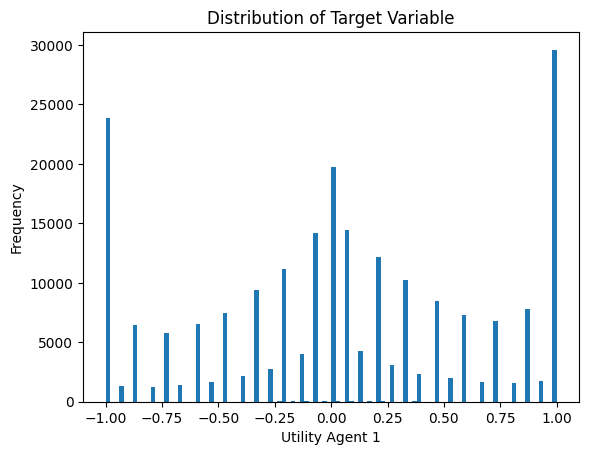

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6120818	test: 0.5498706	best: 0.5498706 (0)	total: 152ms	remaining: 7m 35s


50:	learn: 0.3806933	test: 0.4603161	best: 0.4603161 (50)	total: 4.83s	remaining: 4m 39s


100:	learn: 0.3400409	test: 0.4431510	best: 0.4431510 (100)	total: 9.17s	remaining: 4m 23s


150:	learn: 0.3182495	test: 0.4366414	best: 0.4365048 (149)	total: 13.3s	remaining: 4m 11s


200:	learn: 0.3035333	test: 0.4330410	best: 0.4330410 (200)	total: 17.5s	remaining: 4m 4s


250:	learn: 0.2916016	test: 0.4311997	best: 0.4311997 (250)	total: 21.8s	remaining: 3m 58s


300:	learn: 0.2825328	test: 0.4294406	best: 0.4294335 (299)	total: 26s	remaining: 3m 53s


350:	learn: 0.2749201	test: 0.4280632	best: 0.4280632 (350)	total: 30.3s	remaining: 3m 48s


400:	learn: 0.2683430	test: 0.4270848	best: 0.4270247 (395)	total: 34.6s	remaining: 3m 44s


450:	learn: 0.2624592	test: 0.4265086	best: 0.4265086 (450)	total: 38.8s	remaining: 3m 39s


500:	learn: 0.2569887	test: 0.4256867	best: 0.4256867 (500)	total: 43s	remaining: 3m 34s


550:	learn: 0.2522345	test: 0.4249125	best: 0.4248773 (549)	total: 47.3s	remaining: 3m 30s


600:	learn: 0.2477910	test: 0.4244345	best: 0.4244263 (599)	total: 51.5s	remaining: 3m 25s


650:	learn: 0.2437918	test: 0.4239819	best: 0.4239819 (650)	total: 55.8s	remaining: 3m 21s


700:	learn: 0.2402744	test: 0.4238167	best: 0.4238167 (700)	total: 60s	remaining: 3m 16s


750:	learn: 0.2368664	test: 0.4235408	best: 0.4235243 (749)	total: 1m 4s	remaining: 3m 12s


800:	learn: 0.2334353	test: 0.4234399	best: 0.4233622 (789)	total: 1m 8s	remaining: 3m 8s


850:	learn: 0.2303962	test: 0.4231327	best: 0.4231226 (844)	total: 1m 12s	remaining: 3m 3s


900:	learn: 0.2273031	test: 0.4230244	best: 0.4230244 (900)	total: 1m 17s	remaining: 2m 59s


950:	learn: 0.2243899	test: 0.4226226	best: 0.4226226 (950)	total: 1m 21s	remaining: 2m 55s


1000:	learn: 0.2217225	test: 0.4225389	best: 0.4224911 (986)	total: 1m 25s	remaining: 2m 50s


1050:	learn: 0.2192766	test: 0.4224591	best: 0.4224462 (1030)	total: 1m 29s	remaining: 2m 46s


1100:	learn: 0.2168853	test: 0.4222914	best: 0.4222888 (1098)	total: 1m 33s	remaining: 2m 41s


1150:	learn: 0.2145487	test: 0.4221405	best: 0.4221405 (1150)	total: 1m 38s	remaining: 2m 37s


1200:	learn: 0.2125328	test: 0.4219897	best: 0.4219713 (1197)	total: 1m 42s	remaining: 2m 33s


1250:	learn: 0.2103635	test: 0.4219500	best: 0.4218852 (1237)	total: 1m 46s	remaining: 2m 29s


1300:	learn: 0.2083554	test: 0.4218520	best: 0.4218483 (1285)	total: 1m 50s	remaining: 2m 24s


1350:	learn: 0.2063546	test: 0.4218288	best: 0.4217991 (1344)	total: 1m 55s	remaining: 2m 20s


1400:	learn: 0.2044405	test: 0.4216689	best: 0.4216689 (1400)	total: 1m 59s	remaining: 2m 16s


1450:	learn: 0.2025615	test: 0.4215714	best: 0.4215515 (1438)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2007369	test: 0.4216197	best: 0.4215430 (1477)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.1989225	test: 0.4216507	best: 0.4215430 (1518)	total: 2m 12s	remaining: 2m 3s


1600:	learn: 0.1972056	test: 0.4216905	best: 0.4215430 (1518)	total: 2m 16s	remaining: 1m 59s


1650:	learn: 0.1956326	test: 0.4216727	best: 0.4215430 (1518)	total: 2m 20s	remaining: 1m 54s


1700:	learn: 0.1940499	test: 0.4216890	best: 0.4215430 (1518)	total: 2m 24s	remaining: 1m 50s


1750:	learn: 0.1925514	test: 0.4216814	best: 0.4215430 (1518)	total: 2m 29s	remaining: 1m 46s


1800:	learn: 0.1910956	test: 0.4216295	best: 0.4215430 (1518)	total: 2m 33s	remaining: 1m 42s


1850:	learn: 0.1896409	test: 0.4216268	best: 0.4215430 (1518)	total: 2m 37s	remaining: 1m 37s


1900:	learn: 0.1879928	test: 0.4215992	best: 0.4215430 (1518)	total: 2m 42s	remaining: 1m 33s


1950:	learn: 0.1865091	test: 0.4216497	best: 0.4215430 (1518)	total: 2m 46s	remaining: 1m 29s


2000:	learn: 0.1851019	test: 0.4215406	best: 0.4215406 (2000)	total: 2m 50s	remaining: 1m 25s


2050:	learn: 0.1836484	test: 0.4215598	best: 0.4215064 (2036)	total: 2m 54s	remaining: 1m 20s


2100:	learn: 0.1822690	test: 0.4215389	best: 0.4215064 (2036)	total: 2m 58s	remaining: 1m 16s


2150:	learn: 0.1809594	test: 0.4214635	best: 0.4214531 (2148)	total: 3m 3s	remaining: 1m 12s


2200:	learn: 0.1795649	test: 0.4214848	best: 0.4214272 (2158)	total: 3m 7s	remaining: 1m 8s


2250:	learn: 0.1783323	test: 0.4214129	best: 0.4214102 (2249)	total: 3m 11s	remaining: 1m 3s


2300:	learn: 0.1770483	test: 0.4214329	best: 0.4213968 (2255)	total: 3m 15s	remaining: 59.5s


2350:	learn: 0.1758617	test: 0.4214243	best: 0.4213968 (2255)	total: 3m 20s	remaining: 55.3s


2400:	learn: 0.1744651	test: 0.4214263	best: 0.4213968 (2255)	total: 3m 24s	remaining: 51.1s


2450:	learn: 0.1733226	test: 0.4214292	best: 0.4213968 (2255)	total: 3m 28s	remaining: 46.8s


2500:	learn: 0.1722632	test: 0.4214624	best: 0.4213968 (2255)	total: 3m 33s	remaining: 42.5s


2550:	learn: 0.1710238	test: 0.4214572	best: 0.4213968 (2255)	total: 3m 37s	remaining: 38.3s


2600:	learn: 0.1699016	test: 0.4215211	best: 0.4213968 (2255)	total: 3m 41s	remaining: 34s


2650:	learn: 0.1687984	test: 0.4215715	best: 0.4213968 (2255)	total: 3m 46s	remaining: 29.8s


2700:	learn: 0.1676814	test: 0.4216236	best: 0.4213968 (2255)	total: 3m 50s	remaining: 25.5s


2750:	learn: 0.1666240	test: 0.4216425	best: 0.4213968 (2255)	total: 3m 54s	remaining: 21.2s


2800:	learn: 0.1655871	test: 0.4216462	best: 0.4213968 (2255)	total: 3m 58s	remaining: 17s


2850:	learn: 0.1644678	test: 0.4216854	best: 0.4213968 (2255)	total: 4m 3s	remaining: 12.7s


2900:	learn: 0.1634444	test: 0.4216979	best: 0.4213968 (2255)	total: 4m 7s	remaining: 8.44s


2950:	learn: 0.1624017	test: 0.4216930	best: 0.4213968 (2255)	total: 4m 11s	remaining: 4.18s


2999:	learn: 0.1613435	test: 0.4217139	best: 0.4213968 (2255)	total: 4m 15s	remaining: 0us

bestTest = 0.4213968499
bestIteration = 2255

Shrink model to first 2256 iterations.


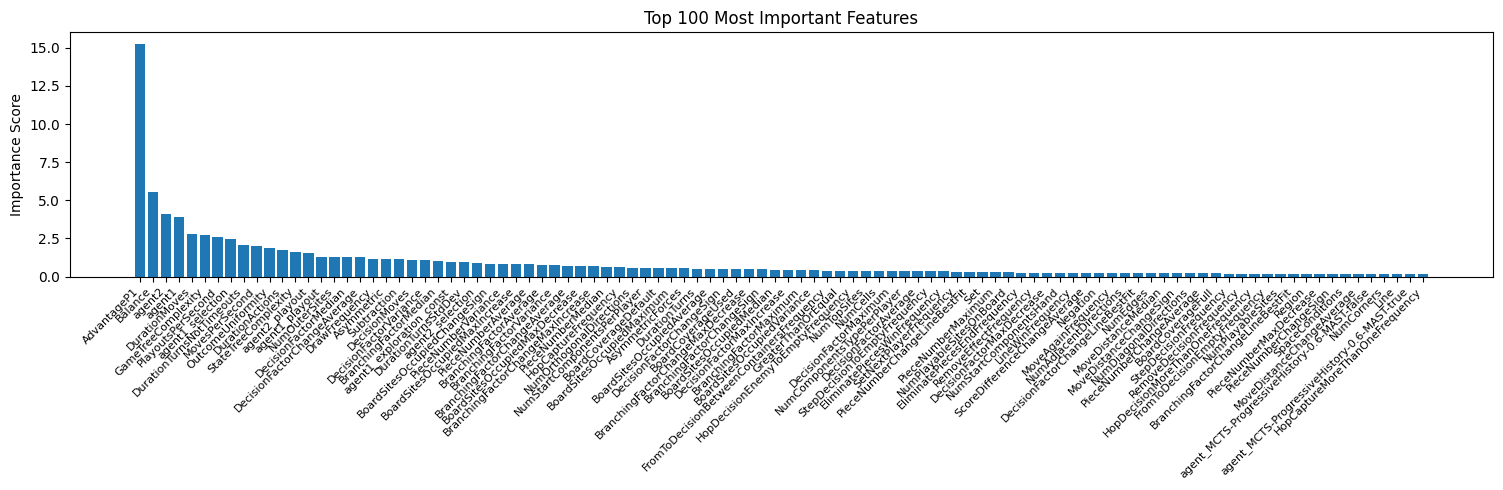

Fold 1 - RMSE: 0.4209489060403922
Fold 2


0:	learn: 0.6060694	test: 0.5796257	best: 0.5796257 (0)	total: 74.1ms	remaining: 3m 42s


50:	learn: 0.3899322	test: 0.4766925	best: 0.4766925 (50)	total: 4.2s	remaining: 4m 2s


100:	learn: 0.3486253	test: 0.4621389	best: 0.4621389 (100)	total: 8.63s	remaining: 4m 7s


150:	learn: 0.3268894	test: 0.4566883	best: 0.4566883 (150)	total: 13.1s	remaining: 4m 6s


200:	learn: 0.3108901	test: 0.4521955	best: 0.4521955 (200)	total: 17.3s	remaining: 4m


250:	learn: 0.2994339	test: 0.4502334	best: 0.4501675 (244)	total: 21.6s	remaining: 3m 56s


300:	learn: 0.2907834	test: 0.4491846	best: 0.4491846 (300)	total: 26s	remaining: 3m 52s


350:	learn: 0.2829980	test: 0.4482137	best: 0.4480713 (323)	total: 30.3s	remaining: 3m 48s


400:	learn: 0.2758634	test: 0.4477365	best: 0.4477365 (400)	total: 34.7s	remaining: 3m 44s


450:	learn: 0.2699987	test: 0.4465652	best: 0.4465340 (448)	total: 39s	remaining: 3m 40s


500:	learn: 0.2639282	test: 0.4458749	best: 0.4458676 (498)	total: 43.3s	remaining: 3m 36s


550:	learn: 0.2586203	test: 0.4452888	best: 0.4451936 (545)	total: 47.7s	remaining: 3m 31s


600:	learn: 0.2548646	test: 0.4446823	best: 0.4446823 (600)	total: 52.2s	remaining: 3m 28s


650:	learn: 0.2506050	test: 0.4445150	best: 0.4444108 (637)	total: 56.5s	remaining: 3m 24s


700:	learn: 0.2468476	test: 0.4439931	best: 0.4439931 (700)	total: 1m	remaining: 3m 19s


750:	learn: 0.2432883	test: 0.4438388	best: 0.4438388 (750)	total: 1m 5s	remaining: 3m 15s


800:	learn: 0.2401405	test: 0.4437303	best: 0.4437303 (800)	total: 1m 9s	remaining: 3m 11s


850:	learn: 0.2370567	test: 0.4435204	best: 0.4435204 (850)	total: 1m 14s	remaining: 3m 7s


900:	learn: 0.2341543	test: 0.4433194	best: 0.4433194 (900)	total: 1m 18s	remaining: 3m 2s


950:	learn: 0.2313783	test: 0.4429248	best: 0.4429048 (949)	total: 1m 22s	remaining: 2m 58s


1000:	learn: 0.2287118	test: 0.4426063	best: 0.4426063 (1000)	total: 1m 27s	remaining: 2m 54s


1050:	learn: 0.2261737	test: 0.4423893	best: 0.4423893 (1050)	total: 1m 31s	remaining: 2m 50s


1100:	learn: 0.2238162	test: 0.4423386	best: 0.4422681 (1084)	total: 1m 36s	remaining: 2m 46s


1150:	learn: 0.2215592	test: 0.4422938	best: 0.4422681 (1084)	total: 1m 40s	remaining: 2m 41s


1200:	learn: 0.2192607	test: 0.4420846	best: 0.4420845 (1198)	total: 1m 45s	remaining: 2m 37s


1250:	learn: 0.2170885	test: 0.4419267	best: 0.4418779 (1242)	total: 1m 49s	remaining: 2m 33s


1300:	learn: 0.2150827	test: 0.4418703	best: 0.4418703 (1300)	total: 1m 54s	remaining: 2m 29s


1350:	learn: 0.2130704	test: 0.4417626	best: 0.4417626 (1350)	total: 1m 58s	remaining: 2m 24s


1400:	learn: 0.2110844	test: 0.4415192	best: 0.4415192 (1400)	total: 2m 2s	remaining: 2m 20s


1450:	learn: 0.2093185	test: 0.4414093	best: 0.4414061 (1443)	total: 2m 7s	remaining: 2m 15s


1500:	learn: 0.2074181	test: 0.4413860	best: 0.4413802 (1472)	total: 2m 11s	remaining: 2m 11s


1550:	learn: 0.2056606	test: 0.4414737	best: 0.4413487 (1525)	total: 2m 16s	remaining: 2m 7s


1600:	learn: 0.2039233	test: 0.4413309	best: 0.4413309 (1600)	total: 2m 20s	remaining: 2m 2s


1650:	learn: 0.2020977	test: 0.4410891	best: 0.4410622 (1647)	total: 2m 24s	remaining: 1m 58s


1700:	learn: 0.2005802	test: 0.4411127	best: 0.4410585 (1661)	total: 2m 29s	remaining: 1m 54s


1750:	learn: 0.1989852	test: 0.4410664	best: 0.4410585 (1661)	total: 2m 33s	remaining: 1m 49s


1800:	learn: 0.1973068	test: 0.4409516	best: 0.4409385 (1799)	total: 2m 38s	remaining: 1m 45s


1850:	learn: 0.1960220	test: 0.4409482	best: 0.4409185 (1837)	total: 2m 42s	remaining: 1m 41s


1900:	learn: 0.1945020	test: 0.4408554	best: 0.4408459 (1886)	total: 2m 47s	remaining: 1m 36s


1950:	learn: 0.1931362	test: 0.4408763	best: 0.4408424 (1932)	total: 2m 51s	remaining: 1m 32s


2000:	learn: 0.1916412	test: 0.4408644	best: 0.4408424 (1932)	total: 2m 56s	remaining: 1m 28s


2050:	learn: 0.1904038	test: 0.4407945	best: 0.4407943 (2049)	total: 3m	remaining: 1m 23s


2100:	learn: 0.1889758	test: 0.4408140	best: 0.4407491 (2058)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.1875712	test: 0.4408310	best: 0.4407491 (2058)	total: 3m 9s	remaining: 1m 14s


2200:	learn: 0.1862389	test: 0.4407492	best: 0.4407491 (2058)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.1849807	test: 0.4407559	best: 0.4407234 (2241)	total: 3m 18s	remaining: 1m 6s


2300:	learn: 0.1837077	test: 0.4407066	best: 0.4407066 (2300)	total: 3m 23s	remaining: 1m 1s


2350:	learn: 0.1825483	test: 0.4406752	best: 0.4406696 (2341)	total: 3m 27s	remaining: 57.3s


2400:	learn: 0.1812193	test: 0.4406044	best: 0.4405968 (2397)	total: 3m 32s	remaining: 52.9s


2450:	learn: 0.1799041	test: 0.4405710	best: 0.4405688 (2447)	total: 3m 36s	remaining: 48.5s


2500:	learn: 0.1787337	test: 0.4405982	best: 0.4405384 (2480)	total: 3m 41s	remaining: 44.1s


2550:	learn: 0.1775275	test: 0.4405782	best: 0.4405384 (2480)	total: 3m 45s	remaining: 39.7s


2600:	learn: 0.1764124	test: 0.4405608	best: 0.4405069 (2585)	total: 3m 50s	remaining: 35.3s


2650:	learn: 0.1751677	test: 0.4406081	best: 0.4405069 (2585)	total: 3m 54s	remaining: 30.9s


2700:	learn: 0.1740228	test: 0.4405922	best: 0.4405069 (2585)	total: 3m 59s	remaining: 26.5s


2750:	learn: 0.1728749	test: 0.4405114	best: 0.4405047 (2743)	total: 4m 3s	remaining: 22s


2800:	learn: 0.1718269	test: 0.4404825	best: 0.4404770 (2799)	total: 4m 8s	remaining: 17.6s


2850:	learn: 0.1707273	test: 0.4404860	best: 0.4404344 (2827)	total: 4m 12s	remaining: 13.2s


2900:	learn: 0.1695585	test: 0.4404515	best: 0.4404344 (2827)	total: 4m 16s	remaining: 8.77s


2950:	learn: 0.1684650	test: 0.4404321	best: 0.4404277 (2946)	total: 4m 21s	remaining: 4.34s


2999:	learn: 0.1674446	test: 0.4404977	best: 0.4404277 (2946)	total: 4m 25s	remaining: 0us

bestTest = 0.4404276955
bestIteration = 2946

Shrink model to first 2947 iterations.


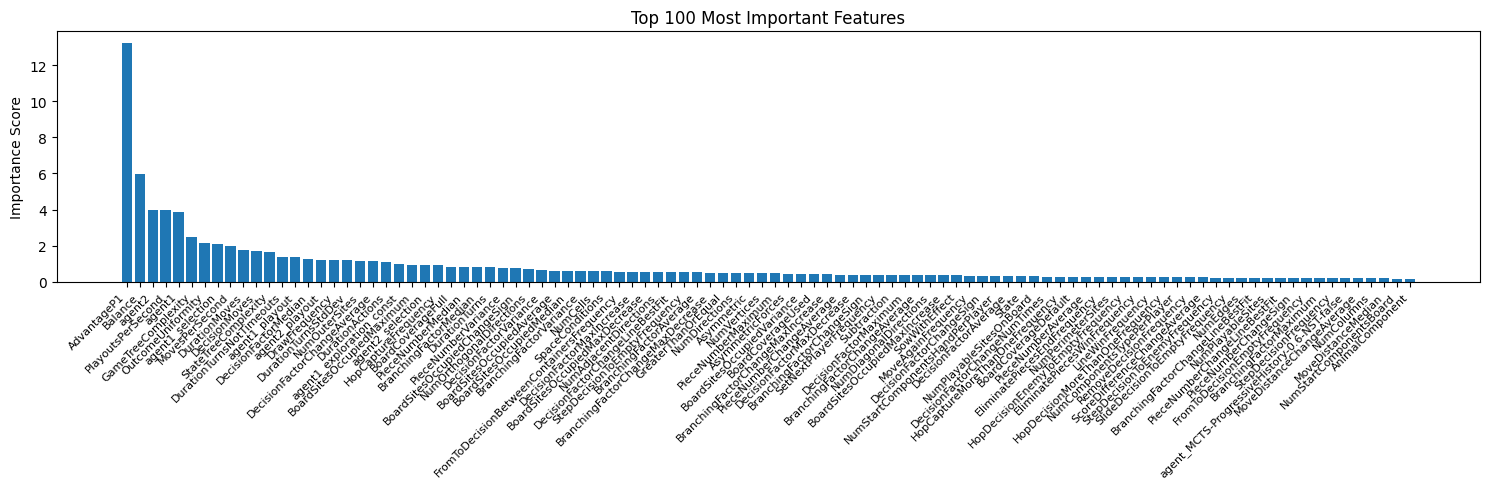

Fold 2 - RMSE: 0.4399976412055517
Fold 3


0:	learn: 0.6024228	test: 0.5961539	best: 0.5961539 (0)	total: 84.2ms	remaining: 4m 12s


50:	learn: 0.3868416	test: 0.4663900	best: 0.4663900 (50)	total: 4.19s	remaining: 4m 2s


100:	learn: 0.3470046	test: 0.4485354	best: 0.4484655 (99)	total: 8.59s	remaining: 4m 6s


150:	learn: 0.3253313	test: 0.4412327	best: 0.4412327 (150)	total: 13s	remaining: 4m 4s


200:	learn: 0.3094353	test: 0.4376896	best: 0.4376124 (198)	total: 17.3s	remaining: 4m 1s


250:	learn: 0.2988335	test: 0.4352200	best: 0.4352171 (249)	total: 21.7s	remaining: 3m 57s


300:	learn: 0.2886851	test: 0.4337210	best: 0.4337210 (300)	total: 26s	remaining: 3m 53s


350:	learn: 0.2806228	test: 0.4327039	best: 0.4327039 (350)	total: 30.4s	remaining: 3m 49s


400:	learn: 0.2739316	test: 0.4319803	best: 0.4319803 (400)	total: 34.7s	remaining: 3m 45s


450:	learn: 0.2678687	test: 0.4312607	best: 0.4312607 (450)	total: 39.2s	remaining: 3m 41s


500:	learn: 0.2623571	test: 0.4306427	best: 0.4306380 (499)	total: 43.6s	remaining: 3m 37s


550:	learn: 0.2573825	test: 0.4301393	best: 0.4301393 (550)	total: 48.1s	remaining: 3m 33s


600:	learn: 0.2530244	test: 0.4297653	best: 0.4297325 (597)	total: 52.5s	remaining: 3m 29s


650:	learn: 0.2491842	test: 0.4292453	best: 0.4292446 (645)	total: 57s	remaining: 3m 25s


700:	learn: 0.2453746	test: 0.4290230	best: 0.4290216 (699)	total: 1m 1s	remaining: 3m 21s


750:	learn: 0.2417538	test: 0.4286986	best: 0.4286986 (750)	total: 1m 5s	remaining: 3m 16s


800:	learn: 0.2389061	test: 0.4286133	best: 0.4286133 (800)	total: 1m 10s	remaining: 3m 12s


850:	learn: 0.2355727	test: 0.4284066	best: 0.4284066 (850)	total: 1m 14s	remaining: 3m 8s


900:	learn: 0.2327275	test: 0.4283574	best: 0.4283027 (885)	total: 1m 19s	remaining: 3m 4s


950:	learn: 0.2299871	test: 0.4283666	best: 0.4283027 (885)	total: 1m 23s	remaining: 2m 59s


1000:	learn: 0.2273273	test: 0.4283227	best: 0.4282737 (993)	total: 1m 27s	remaining: 2m 55s


1050:	learn: 0.2246693	test: 0.4281640	best: 0.4281640 (1050)	total: 1m 32s	remaining: 2m 51s


1100:	learn: 0.2223195	test: 0.4277853	best: 0.4277853 (1100)	total: 1m 36s	remaining: 2m 46s


1150:	learn: 0.2202192	test: 0.4276491	best: 0.4276491 (1150)	total: 1m 41s	remaining: 2m 42s


1200:	learn: 0.2179998	test: 0.4276805	best: 0.4275625 (1177)	total: 1m 45s	remaining: 2m 38s


1250:	learn: 0.2157597	test: 0.4275874	best: 0.4275625 (1177)	total: 1m 50s	remaining: 2m 33s


1300:	learn: 0.2136021	test: 0.4273992	best: 0.4273992 (1300)	total: 1m 54s	remaining: 2m 29s


1350:	learn: 0.2116757	test: 0.4272817	best: 0.4272787 (1336)	total: 1m 58s	remaining: 2m 25s


1400:	learn: 0.2096979	test: 0.4272715	best: 0.4272670 (1398)	total: 2m 3s	remaining: 2m 20s


1450:	learn: 0.2077179	test: 0.4272060	best: 0.4271963 (1448)	total: 2m 7s	remaining: 2m 16s


1500:	learn: 0.2058166	test: 0.4271350	best: 0.4271197 (1480)	total: 2m 12s	remaining: 2m 11s


1550:	learn: 0.2041329	test: 0.4270129	best: 0.4270129 (1550)	total: 2m 16s	remaining: 2m 7s


1600:	learn: 0.2023392	test: 0.4268632	best: 0.4268276 (1589)	total: 2m 21s	remaining: 2m 3s


1650:	learn: 0.2006970	test: 0.4267784	best: 0.4267671 (1641)	total: 2m 25s	remaining: 1m 58s


1700:	learn: 0.1990573	test: 0.4267119	best: 0.4266936 (1698)	total: 2m 29s	remaining: 1m 54s


1750:	learn: 0.1974682	test: 0.4266145	best: 0.4266021 (1749)	total: 2m 34s	remaining: 1m 50s


1800:	learn: 0.1958106	test: 0.4266653	best: 0.4266009 (1766)	total: 2m 38s	remaining: 1m 45s


1850:	learn: 0.1943252	test: 0.4265547	best: 0.4265547 (1850)	total: 2m 43s	remaining: 1m 41s


1900:	learn: 0.1927776	test: 0.4265007	best: 0.4264823 (1875)	total: 2m 47s	remaining: 1m 36s


1950:	learn: 0.1914009	test: 0.4265016	best: 0.4264324 (1918)	total: 2m 52s	remaining: 1m 32s


2000:	learn: 0.1899369	test: 0.4264947	best: 0.4264324 (1918)	total: 2m 56s	remaining: 1m 28s


2050:	learn: 0.1885645	test: 0.4264999	best: 0.4264324 (1918)	total: 3m	remaining: 1m 23s


2100:	learn: 0.1872313	test: 0.4264996	best: 0.4264324 (1918)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.1859353	test: 0.4265113	best: 0.4264324 (1918)	total: 3m 9s	remaining: 1m 14s


2200:	learn: 0.1846574	test: 0.4264817	best: 0.4264324 (1918)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.1833791	test: 0.4265527	best: 0.4264324 (1918)	total: 3m 18s	remaining: 1m 6s


2300:	learn: 0.1819646	test: 0.4265644	best: 0.4264324 (1918)	total: 3m 22s	remaining: 1m 1s


2350:	learn: 0.1807627	test: 0.4264773	best: 0.4264324 (1918)	total: 3m 27s	remaining: 57.2s


2400:	learn: 0.1795786	test: 0.4264066	best: 0.4264066 (2400)	total: 3m 31s	remaining: 52.8s


2450:	learn: 0.1783452	test: 0.4264227	best: 0.4263755 (2406)	total: 3m 36s	remaining: 48.4s


2500:	learn: 0.1770751	test: 0.4263546	best: 0.4263368 (2489)	total: 3m 40s	remaining: 44s


2550:	learn: 0.1758760	test: 0.4263515	best: 0.4263368 (2489)	total: 3m 45s	remaining: 39.6s


2600:	learn: 0.1747952	test: 0.4263623	best: 0.4263368 (2489)	total: 3m 49s	remaining: 35.2s


2650:	learn: 0.1737383	test: 0.4263382	best: 0.4263249 (2644)	total: 3m 53s	remaining: 30.8s


2700:	learn: 0.1725638	test: 0.4263232	best: 0.4262925 (2686)	total: 3m 58s	remaining: 26.4s


2750:	learn: 0.1714780	test: 0.4263551	best: 0.4262925 (2686)	total: 4m 2s	remaining: 22s


2800:	learn: 0.1703523	test: 0.4263525	best: 0.4262925 (2686)	total: 4m 7s	remaining: 17.6s


2850:	learn: 0.1692154	test: 0.4263825	best: 0.4262925 (2686)	total: 4m 11s	remaining: 13.1s


2900:	learn: 0.1681718	test: 0.4263383	best: 0.4262925 (2686)	total: 4m 15s	remaining: 8.73s


2950:	learn: 0.1670630	test: 0.4263409	best: 0.4262925 (2686)	total: 4m 20s	remaining: 4.32s


2999:	learn: 0.1659848	test: 0.4262500	best: 0.4262493 (2998)	total: 4m 24s	remaining: 0us

bestTest = 0.4262492842
bestIteration = 2998

Shrink model to first 2999 iterations.


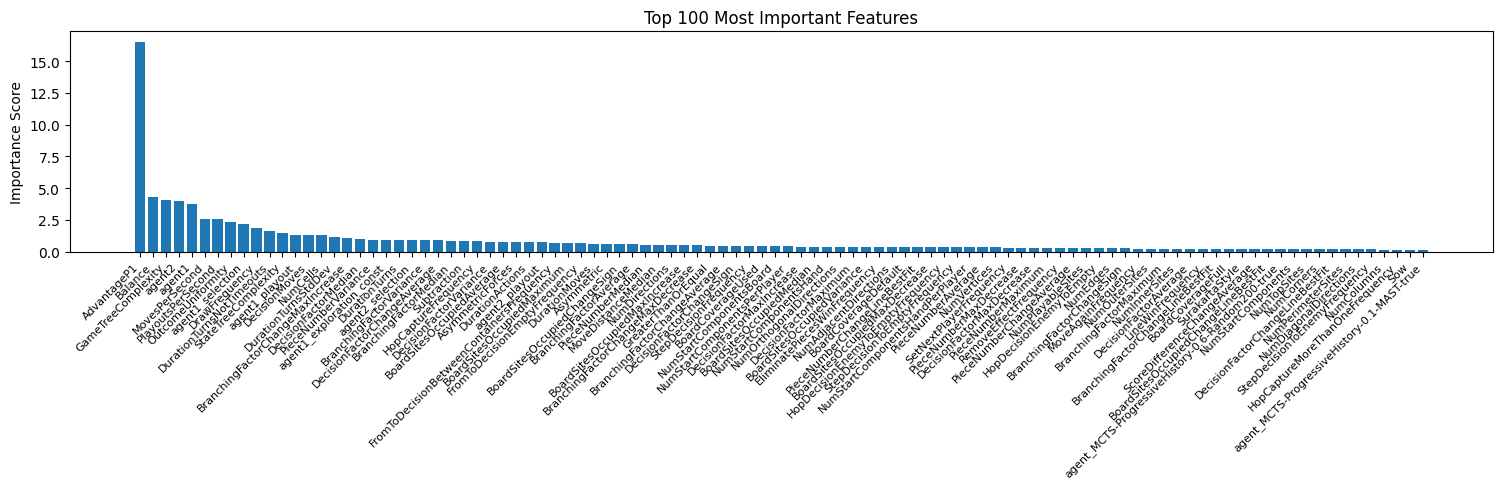

Fold 3 - RMSE: 0.4255182064288579
Fold 4


0:	learn: 0.6027028	test: 0.5907413	best: 0.5907413 (0)	total: 78.3ms	remaining: 3m 54s


50:	learn: 0.3873663	test: 0.4857023	best: 0.4857023 (50)	total: 4.08s	remaining: 3m 55s


100:	learn: 0.3472127	test: 0.4668528	best: 0.4668528 (100)	total: 8.38s	remaining: 4m


150:	learn: 0.3245227	test: 0.4593566	best: 0.4593566 (150)	total: 12.7s	remaining: 3m 59s


200:	learn: 0.3087314	test: 0.4550046	best: 0.4550046 (200)	total: 17s	remaining: 3m 57s


250:	learn: 0.2966921	test: 0.4524828	best: 0.4524765 (249)	total: 21.3s	remaining: 3m 53s


300:	learn: 0.2875328	test: 0.4507539	best: 0.4507539 (300)	total: 25.6s	remaining: 3m 49s


350:	learn: 0.2795968	test: 0.4495439	best: 0.4495433 (346)	total: 29.9s	remaining: 3m 45s


400:	learn: 0.2727913	test: 0.4484408	best: 0.4483688 (398)	total: 34.2s	remaining: 3m 41s


450:	learn: 0.2668592	test: 0.4477793	best: 0.4477099 (446)	total: 38.5s	remaining: 3m 37s


500:	learn: 0.2612841	test: 0.4467649	best: 0.4467649 (500)	total: 42.9s	remaining: 3m 34s


550:	learn: 0.2563535	test: 0.4461935	best: 0.4461935 (550)	total: 47.3s	remaining: 3m 30s


600:	learn: 0.2518090	test: 0.4456348	best: 0.4456348 (600)	total: 51.7s	remaining: 3m 26s


650:	learn: 0.2481565	test: 0.4450094	best: 0.4450094 (650)	total: 56s	remaining: 3m 22s


700:	learn: 0.2442680	test: 0.4446990	best: 0.4446713 (698)	total: 1m	remaining: 3m 18s


750:	learn: 0.2405919	test: 0.4443676	best: 0.4443676 (750)	total: 1m 4s	remaining: 3m 13s


800:	learn: 0.2370731	test: 0.4441034	best: 0.4440801 (798)	total: 1m 8s	remaining: 3m 9s


850:	learn: 0.2340362	test: 0.4439260	best: 0.4438997 (832)	total: 1m 13s	remaining: 3m 5s


900:	learn: 0.2311298	test: 0.4437932	best: 0.4437932 (900)	total: 1m 17s	remaining: 3m


950:	learn: 0.2282930	test: 0.4435818	best: 0.4435818 (950)	total: 1m 21s	remaining: 2m 56s


1000:	learn: 0.2256568	test: 0.4433756	best: 0.4433466 (994)	total: 1m 26s	remaining: 2m 52s


1050:	learn: 0.2228491	test: 0.4432380	best: 0.4432338 (1049)	total: 1m 30s	remaining: 2m 48s


1100:	learn: 0.2204595	test: 0.4432364	best: 0.4431900 (1075)	total: 1m 34s	remaining: 2m 43s


1150:	learn: 0.2182267	test: 0.4430978	best: 0.4430976 (1149)	total: 1m 39s	remaining: 2m 39s


1200:	learn: 0.2161519	test: 0.4431268	best: 0.4430635 (1168)	total: 1m 43s	remaining: 2m 35s


1250:	learn: 0.2140149	test: 0.4429359	best: 0.4429217 (1246)	total: 1m 48s	remaining: 2m 31s


1300:	learn: 0.2119873	test: 0.4429100	best: 0.4428662 (1280)	total: 1m 52s	remaining: 2m 26s


1350:	learn: 0.2100409	test: 0.4427722	best: 0.4427722 (1350)	total: 1m 56s	remaining: 2m 22s


1400:	learn: 0.2081036	test: 0.4426544	best: 0.4426200 (1396)	total: 2m 1s	remaining: 2m 18s


1450:	learn: 0.2062358	test: 0.4425618	best: 0.4425565 (1447)	total: 2m 5s	remaining: 2m 13s


1500:	learn: 0.2044994	test: 0.4425403	best: 0.4425040 (1474)	total: 2m 9s	remaining: 2m 9s


1550:	learn: 0.2028501	test: 0.4424770	best: 0.4424258 (1543)	total: 2m 14s	remaining: 2m 5s


1600:	learn: 0.2011897	test: 0.4425906	best: 0.4424258 (1543)	total: 2m 18s	remaining: 2m 1s


1650:	learn: 0.1994845	test: 0.4425332	best: 0.4424258 (1543)	total: 2m 22s	remaining: 1m 56s


1700:	learn: 0.1978878	test: 0.4424871	best: 0.4424258 (1543)	total: 2m 27s	remaining: 1m 52s


1750:	learn: 0.1962813	test: 0.4424181	best: 0.4424181 (1750)	total: 2m 31s	remaining: 1m 48s


1800:	learn: 0.1947252	test: 0.4423834	best: 0.4423636 (1789)	total: 2m 36s	remaining: 1m 43s


1850:	learn: 0.1932390	test: 0.4423367	best: 0.4423209 (1841)	total: 2m 40s	remaining: 1m 39s


1900:	learn: 0.1918416	test: 0.4423409	best: 0.4422917 (1865)	total: 2m 44s	remaining: 1m 35s


1950:	learn: 0.1903677	test: 0.4423286	best: 0.4422917 (1865)	total: 2m 49s	remaining: 1m 30s


2000:	learn: 0.1889425	test: 0.4422472	best: 0.4422458 (1999)	total: 2m 53s	remaining: 1m 26s


2050:	learn: 0.1875509	test: 0.4422986	best: 0.4422295 (2036)	total: 2m 57s	remaining: 1m 22s


2100:	learn: 0.1861792	test: 0.4422428	best: 0.4422295 (2036)	total: 3m 2s	remaining: 1m 17s


2150:	learn: 0.1847738	test: 0.4422044	best: 0.4421876 (2141)	total: 3m 6s	remaining: 1m 13s


2200:	learn: 0.1834016	test: 0.4421723	best: 0.4421663 (2189)	total: 3m 10s	remaining: 1m 9s


2250:	learn: 0.1818855	test: 0.4420975	best: 0.4420757 (2234)	total: 3m 15s	remaining: 1m 4s


2300:	learn: 0.1805900	test: 0.4420376	best: 0.4420058 (2279)	total: 3m 19s	remaining: 1m


2350:	learn: 0.1793424	test: 0.4420735	best: 0.4420058 (2279)	total: 3m 23s	remaining: 56.3s


2400:	learn: 0.1781756	test: 0.4419851	best: 0.4419808 (2373)	total: 3m 28s	remaining: 52s


2450:	learn: 0.1768988	test: 0.4420137	best: 0.4419808 (2373)	total: 3m 32s	remaining: 47.6s


2500:	learn: 0.1756085	test: 0.4419756	best: 0.4419756 (2500)	total: 3m 36s	remaining: 43.3s


2550:	learn: 0.1744318	test: 0.4419206	best: 0.4419154 (2544)	total: 3m 41s	remaining: 38.9s


2600:	learn: 0.1732833	test: 0.4420090	best: 0.4419154 (2544)	total: 3m 45s	remaining: 34.6s


2650:	learn: 0.1721291	test: 0.4420010	best: 0.4419154 (2544)	total: 3m 50s	remaining: 30.3s


2700:	learn: 0.1710534	test: 0.4420423	best: 0.4419154 (2544)	total: 3m 54s	remaining: 26s


2750:	learn: 0.1699483	test: 0.4420308	best: 0.4419154 (2544)	total: 3m 58s	remaining: 21.6s


2800:	learn: 0.1688254	test: 0.4420749	best: 0.4419154 (2544)	total: 4m 3s	remaining: 17.3s


2850:	learn: 0.1676635	test: 0.4421047	best: 0.4419154 (2544)	total: 4m 7s	remaining: 12.9s


2900:	learn: 0.1666113	test: 0.4421023	best: 0.4419154 (2544)	total: 4m 11s	remaining: 8.6s


2950:	learn: 0.1655548	test: 0.4421229	best: 0.4419154 (2544)	total: 4m 16s	remaining: 4.26s


2999:	learn: 0.1645149	test: 0.4421246	best: 0.4419154 (2544)	total: 4m 20s	remaining: 0us

bestTest = 0.4419154232
bestIteration = 2544

Shrink model to first 2545 iterations.


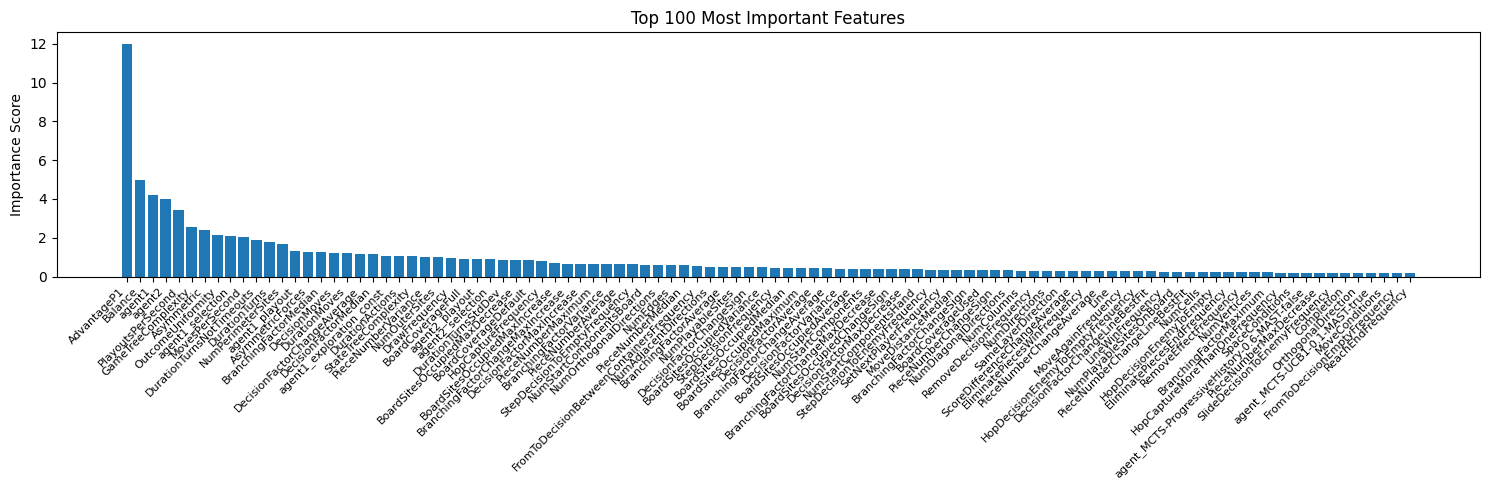

Fold 4 - RMSE: 0.4410554132410694
Fold 5


0:	learn: 0.6145637	test: 0.5440953	best: 0.5440953 (0)	total: 66.1ms	remaining: 3m 18s


50:	learn: 0.3938244	test: 0.4508902	best: 0.4508902 (50)	total: 4.05s	remaining: 3m 54s


100:	learn: 0.3530484	test: 0.4303017	best: 0.4302640 (99)	total: 8.34s	remaining: 3m 59s


150:	learn: 0.3305591	test: 0.4226671	best: 0.4226671 (150)	total: 12.6s	remaining: 3m 56s


200:	learn: 0.3150309	test: 0.4181474	best: 0.4181356 (199)	total: 16.8s	remaining: 3m 53s


250:	learn: 0.3030905	test: 0.4142568	best: 0.4142568 (250)	total: 21s	remaining: 3m 50s


300:	learn: 0.2932379	test: 0.4121001	best: 0.4121001 (300)	total: 25.2s	remaining: 3m 45s


350:	learn: 0.2850382	test: 0.4114658	best: 0.4114194 (347)	total: 29.4s	remaining: 3m 41s


400:	learn: 0.2778435	test: 0.4102698	best: 0.4102698 (400)	total: 33.6s	remaining: 3m 37s


450:	learn: 0.2716754	test: 0.4093148	best: 0.4092521 (447)	total: 37.8s	remaining: 3m 33s


500:	learn: 0.2661281	test: 0.4088835	best: 0.4088187 (496)	total: 42.1s	remaining: 3m 30s


550:	learn: 0.2607068	test: 0.4089399	best: 0.4088187 (496)	total: 46.3s	remaining: 3m 25s


600:	learn: 0.2560620	test: 0.4084076	best: 0.4083661 (599)	total: 50.6s	remaining: 3m 21s


650:	learn: 0.2518407	test: 0.4083075	best: 0.4082524 (646)	total: 54.8s	remaining: 3m 17s


700:	learn: 0.2479378	test: 0.4078607	best: 0.4077356 (696)	total: 59.1s	remaining: 3m 13s


750:	learn: 0.2445498	test: 0.4076932	best: 0.4076206 (741)	total: 1m 3s	remaining: 3m 9s


800:	learn: 0.2413138	test: 0.4076599	best: 0.4075528 (763)	total: 1m 7s	remaining: 3m 6s


850:	learn: 0.2381921	test: 0.4074804	best: 0.4074804 (850)	total: 1m 12s	remaining: 3m 2s


900:	learn: 0.2352674	test: 0.4076836	best: 0.4074804 (850)	total: 1m 16s	remaining: 2m 57s


950:	learn: 0.2320961	test: 0.4077869	best: 0.4074804 (850)	total: 1m 20s	remaining: 2m 53s


1000:	learn: 0.2291822	test: 0.4075247	best: 0.4074804 (850)	total: 1m 24s	remaining: 2m 49s


1050:	learn: 0.2265590	test: 0.4071818	best: 0.4071818 (1050)	total: 1m 29s	remaining: 2m 45s


1100:	learn: 0.2242467	test: 0.4070874	best: 0.4070809 (1096)	total: 1m 33s	remaining: 2m 41s


1150:	learn: 0.2217994	test: 0.4071578	best: 0.4070570 (1114)	total: 1m 37s	remaining: 2m 37s


1200:	learn: 0.2198694	test: 0.4070792	best: 0.4070570 (1114)	total: 1m 42s	remaining: 2m 33s


1250:	learn: 0.2175932	test: 0.4070552	best: 0.4070434 (1205)	total: 1m 46s	remaining: 2m 28s


1300:	learn: 0.2155825	test: 0.4070755	best: 0.4069799 (1261)	total: 1m 50s	remaining: 2m 24s


1350:	learn: 0.2134619	test: 0.4068960	best: 0.4068960 (1350)	total: 1m 55s	remaining: 2m 20s


1400:	learn: 0.2113948	test: 0.4068492	best: 0.4068277 (1396)	total: 1m 59s	remaining: 2m 16s


1450:	learn: 0.2095096	test: 0.4068548	best: 0.4068277 (1396)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2075870	test: 0.4067905	best: 0.4067877 (1495)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.2056578	test: 0.4066305	best: 0.4066277 (1548)	total: 2m 12s	remaining: 2m 3s


1600:	learn: 0.2038601	test: 0.4067089	best: 0.4066036 (1569)	total: 2m 16s	remaining: 1m 59s


1650:	learn: 0.2021082	test: 0.4066460	best: 0.4066036 (1569)	total: 2m 20s	remaining: 1m 55s


1700:	learn: 0.2004203	test: 0.4066597	best: 0.4065899 (1675)	total: 2m 25s	remaining: 1m 50s


1750:	learn: 0.1987931	test: 0.4066570	best: 0.4065899 (1675)	total: 2m 29s	remaining: 1m 46s


1800:	learn: 0.1971545	test: 0.4066989	best: 0.4065899 (1675)	total: 2m 33s	remaining: 1m 42s


1850:	learn: 0.1955438	test: 0.4066967	best: 0.4065899 (1675)	total: 2m 37s	remaining: 1m 38s


1900:	learn: 0.1939755	test: 0.4067576	best: 0.4065899 (1675)	total: 2m 42s	remaining: 1m 33s


1950:	learn: 0.1924652	test: 0.4067477	best: 0.4065899 (1675)	total: 2m 46s	remaining: 1m 29s


2000:	learn: 0.1910378	test: 0.4067481	best: 0.4065899 (1675)	total: 2m 50s	remaining: 1m 25s


2050:	learn: 0.1894431	test: 0.4067705	best: 0.4065899 (1675)	total: 2m 55s	remaining: 1m 21s


2100:	learn: 0.1881508	test: 0.4067325	best: 0.4065899 (1675)	total: 2m 59s	remaining: 1m 16s


2150:	learn: 0.1867031	test: 0.4067919	best: 0.4065899 (1675)	total: 3m 3s	remaining: 1m 12s


2200:	learn: 0.1854057	test: 0.4068339	best: 0.4065899 (1675)	total: 3m 8s	remaining: 1m 8s


2250:	learn: 0.1839489	test: 0.4069256	best: 0.4065899 (1675)	total: 3m 12s	remaining: 1m 4s


2300:	learn: 0.1826810	test: 0.4069167	best: 0.4065899 (1675)	total: 3m 16s	remaining: 59.8s


2350:	learn: 0.1812376	test: 0.4069748	best: 0.4065899 (1675)	total: 3m 21s	remaining: 55.5s


2400:	learn: 0.1799210	test: 0.4069297	best: 0.4065899 (1675)	total: 3m 25s	remaining: 51.3s


2450:	learn: 0.1787174	test: 0.4068766	best: 0.4065899 (1675)	total: 3m 29s	remaining: 47s


2500:	learn: 0.1774189	test: 0.4068866	best: 0.4065899 (1675)	total: 3m 34s	remaining: 42.7s


2550:	learn: 0.1762064	test: 0.4068806	best: 0.4065899 (1675)	total: 3m 38s	remaining: 38.5s


2600:	learn: 0.1749760	test: 0.4068750	best: 0.4065899 (1675)	total: 3m 42s	remaining: 34.2s


2650:	learn: 0.1738373	test: 0.4068961	best: 0.4065899 (1675)	total: 3m 47s	remaining: 29.9s


2700:	learn: 0.1727205	test: 0.4068902	best: 0.4065899 (1675)	total: 3m 51s	remaining: 25.6s


2750:	learn: 0.1714784	test: 0.4068581	best: 0.4065899 (1675)	total: 3m 55s	remaining: 21.3s


2800:	learn: 0.1702830	test: 0.4068242	best: 0.4065899 (1675)	total: 4m	remaining: 17.1s


2850:	learn: 0.1692203	test: 0.4068239	best: 0.4065899 (1675)	total: 4m 4s	remaining: 12.8s


2900:	learn: 0.1682329	test: 0.4068555	best: 0.4065899 (1675)	total: 4m 8s	remaining: 8.49s


2950:	learn: 0.1670960	test: 0.4068620	best: 0.4065899 (1675)	total: 4m 13s	remaining: 4.2s


2999:	learn: 0.1659861	test: 0.4068411	best: 0.4065899 (1675)	total: 4m 17s	remaining: 0us

bestTest = 0.4065899466
bestIteration = 1675

Shrink model to first 1676 iterations.


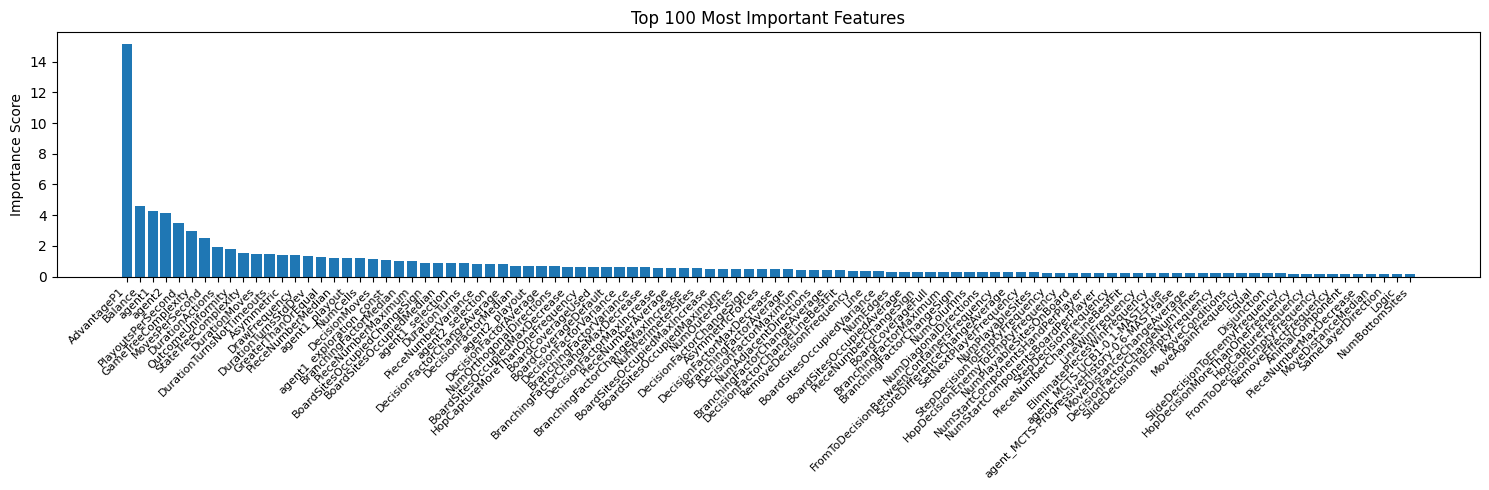

Fold 5 - RMSE: 0.4062654396664512
List of oof scores: [0.4209489060403922, 0.4399976412055517, 0.4255182064288579, 0.4410554132410694, 0.4062654396664512]
Average oof score: 0.4267571213164644


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6164123	test: 0.5308996	best: 0.5308996 (0)	total: 75.7ms	remaining: 3m 46s


50:	learn: 0.3927068	test: 0.4479438	best: 0.4479438 (50)	total: 4.01s	remaining: 3m 52s


100:	learn: 0.3512613	test: 0.4282824	best: 0.4282824 (100)	total: 8.25s	remaining: 3m 56s


150:	learn: 0.3264133	test: 0.4220452	best: 0.4220452 (150)	total: 12.4s	remaining: 3m 54s


200:	learn: 0.3108219	test: 0.4190355	best: 0.4188920 (184)	total: 16.6s	remaining: 3m 50s


250:	learn: 0.2996614	test: 0.4172328	best: 0.4172328 (250)	total: 20.8s	remaining: 3m 47s


300:	learn: 0.2895566	test: 0.4151116	best: 0.4151116 (300)	total: 24.9s	remaining: 3m 43s


350:	learn: 0.2814464	test: 0.4139859	best: 0.4139667 (344)	total: 29.1s	remaining: 3m 39s


400:	learn: 0.2743756	test: 0.4130194	best: 0.4130063 (399)	total: 33.3s	remaining: 3m 35s


450:	learn: 0.2681642	test: 0.4121236	best: 0.4121078 (443)	total: 37.5s	remaining: 3m 31s


500:	learn: 0.2626243	test: 0.4115749	best: 0.4115513 (495)	total: 41.7s	remaining: 3m 28s


550:	learn: 0.2578030	test: 0.4110157	best: 0.4109690 (548)	total: 46s	remaining: 3m 24s


600:	learn: 0.2529902	test: 0.4105939	best: 0.4105939 (600)	total: 50.2s	remaining: 3m 20s


650:	learn: 0.2488244	test: 0.4101245	best: 0.4101245 (650)	total: 54.4s	remaining: 3m 16s


700:	learn: 0.2447437	test: 0.4098941	best: 0.4098649 (665)	total: 58.7s	remaining: 3m 12s


750:	learn: 0.2410040	test: 0.4097885	best: 0.4097570 (746)	total: 1m 2s	remaining: 3m 8s


800:	learn: 0.2375025	test: 0.4095722	best: 0.4095722 (800)	total: 1m 7s	remaining: 3m 4s


850:	learn: 0.2344386	test: 0.4094371	best: 0.4093359 (838)	total: 1m 11s	remaining: 3m


900:	learn: 0.2314096	test: 0.4091722	best: 0.4091068 (899)	total: 1m 15s	remaining: 2m 56s


950:	learn: 0.2286992	test: 0.4090972	best: 0.4090297 (937)	total: 1m 19s	remaining: 2m 52s


1000:	learn: 0.2260844	test: 0.4089881	best: 0.4089863 (999)	total: 1m 24s	remaining: 2m 47s


1050:	learn: 0.2236678	test: 0.4088593	best: 0.4088043 (1044)	total: 1m 28s	remaining: 2m 43s


1100:	learn: 0.2210260	test: 0.4087320	best: 0.4087287 (1097)	total: 1m 32s	remaining: 2m 39s


1150:	learn: 0.2186970	test: 0.4085848	best: 0.4085711 (1149)	total: 1m 36s	remaining: 2m 35s


1200:	learn: 0.2163679	test: 0.4085457	best: 0.4085136 (1160)	total: 1m 41s	remaining: 2m 31s


1250:	learn: 0.2140105	test: 0.4084161	best: 0.4084103 (1249)	total: 1m 45s	remaining: 2m 27s


1300:	learn: 0.2118188	test: 0.4083555	best: 0.4083304 (1293)	total: 1m 49s	remaining: 2m 23s


1350:	learn: 0.2098793	test: 0.4082660	best: 0.4082618 (1347)	total: 1m 53s	remaining: 2m 19s


1400:	learn: 0.2079245	test: 0.4081919	best: 0.4081784 (1392)	total: 1m 58s	remaining: 2m 14s


1450:	learn: 0.2059643	test: 0.4080895	best: 0.4080871 (1433)	total: 2m 2s	remaining: 2m 10s


1500:	learn: 0.2040908	test: 0.4078845	best: 0.4078788 (1498)	total: 2m 6s	remaining: 2m 6s


1550:	learn: 0.2022977	test: 0.4077957	best: 0.4077675 (1542)	total: 2m 10s	remaining: 2m 2s


1600:	learn: 0.2005371	test: 0.4077702	best: 0.4077494 (1577)	total: 2m 15s	remaining: 1m 58s


1650:	learn: 0.1989666	test: 0.4076281	best: 0.4076244 (1648)	total: 2m 19s	remaining: 1m 53s


1700:	learn: 0.1974458	test: 0.4076378	best: 0.4076146 (1661)	total: 2m 23s	remaining: 1m 49s


1750:	learn: 0.1958609	test: 0.4076401	best: 0.4075980 (1715)	total: 2m 27s	remaining: 1m 45s


1800:	learn: 0.1942754	test: 0.4076633	best: 0.4075980 (1715)	total: 2m 32s	remaining: 1m 41s


1850:	learn: 0.1929234	test: 0.4077051	best: 0.4075980 (1715)	total: 2m 36s	remaining: 1m 37s


1900:	learn: 0.1915157	test: 0.4076617	best: 0.4075980 (1715)	total: 2m 40s	remaining: 1m 32s


1950:	learn: 0.1901490	test: 0.4076094	best: 0.4075980 (1715)	total: 2m 45s	remaining: 1m 28s


2000:	learn: 0.1887171	test: 0.4075674	best: 0.4075621 (1996)	total: 2m 49s	remaining: 1m 24s


2050:	learn: 0.1872876	test: 0.4074871	best: 0.4074771 (2044)	total: 2m 53s	remaining: 1m 20s


2100:	learn: 0.1858715	test: 0.4075013	best: 0.4074538 (2059)	total: 2m 58s	remaining: 1m 16s


2150:	learn: 0.1845119	test: 0.4075225	best: 0.4074538 (2059)	total: 3m 2s	remaining: 1m 11s


2200:	learn: 0.1831279	test: 0.4075177	best: 0.4074538 (2059)	total: 3m 6s	remaining: 1m 7s


2250:	learn: 0.1818872	test: 0.4075344	best: 0.4074538 (2059)	total: 3m 10s	remaining: 1m 3s


2300:	learn: 0.1805880	test: 0.4074583	best: 0.4074538 (2059)	total: 3m 15s	remaining: 59.3s


2350:	learn: 0.1792709	test: 0.4074218	best: 0.4073980 (2323)	total: 3m 19s	remaining: 55s


2400:	learn: 0.1779977	test: 0.4074353	best: 0.4073980 (2323)	total: 3m 23s	remaining: 50.8s


2450:	learn: 0.1767362	test: 0.4074377	best: 0.4073980 (2323)	total: 3m 27s	remaining: 46.6s


2500:	learn: 0.1754836	test: 0.4074397	best: 0.4073970 (2477)	total: 3m 32s	remaining: 42.3s


2550:	learn: 0.1743042	test: 0.4074262	best: 0.4073759 (2539)	total: 3m 36s	remaining: 38.1s


2600:	learn: 0.1731067	test: 0.4074483	best: 0.4073759 (2539)	total: 3m 40s	remaining: 33.9s


2650:	learn: 0.1718415	test: 0.4074993	best: 0.4073759 (2539)	total: 3m 44s	remaining: 29.6s


2700:	learn: 0.1706857	test: 0.4075332	best: 0.4073759 (2539)	total: 3m 49s	remaining: 25.4s


2750:	learn: 0.1695515	test: 0.4074432	best: 0.4073759 (2539)	total: 3m 53s	remaining: 21.1s


2800:	learn: 0.1684498	test: 0.4074067	best: 0.4073697 (2778)	total: 3m 57s	remaining: 16.9s


2850:	learn: 0.1673439	test: 0.4073852	best: 0.4073664 (2842)	total: 4m 2s	remaining: 12.7s


2900:	learn: 0.1662967	test: 0.4074069	best: 0.4073664 (2842)	total: 4m 6s	remaining: 8.41s


2950:	learn: 0.1652170	test: 0.4073860	best: 0.4073664 (2842)	total: 4m 10s	remaining: 4.16s


2999:	learn: 0.1641949	test: 0.4073364	best: 0.4073272 (2997)	total: 4m 14s	remaining: 0us

bestTest = 0.4073271831
bestIteration = 2997

Shrink model to first 2998 iterations.


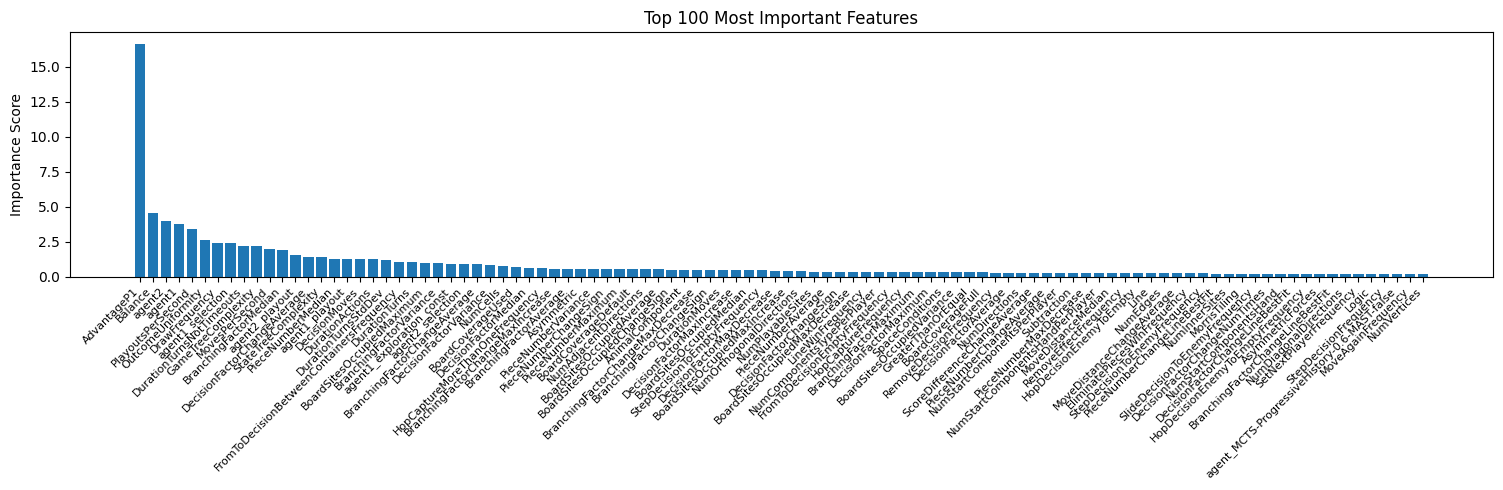

Fold 1 - RMSE: 0.40700443680379966
Fold 2


0:	learn: 0.6144499	test: 0.5379407	best: 0.5379407 (0)	total: 76.4ms	remaining: 3m 49s


50:	learn: 0.3907393	test: 0.4251745	best: 0.4251745 (50)	total: 4.08s	remaining: 3m 56s


100:	learn: 0.3519405	test: 0.4123006	best: 0.4123006 (100)	total: 8.37s	remaining: 4m


150:	learn: 0.3281015	test: 0.4069487	best: 0.4069487 (150)	total: 12.6s	remaining: 3m 58s


200:	learn: 0.3114516	test: 0.4033298	best: 0.4032859 (196)	total: 16.8s	remaining: 3m 54s


250:	learn: 0.2998401	test: 0.4023388	best: 0.4023388 (250)	total: 21s	remaining: 3m 50s


300:	learn: 0.2895022	test: 0.4011600	best: 0.4011600 (300)	total: 25.3s	remaining: 3m 46s


350:	learn: 0.2810224	test: 0.4008048	best: 0.4007929 (348)	total: 29.5s	remaining: 3m 42s


400:	learn: 0.2736013	test: 0.3998431	best: 0.3998162 (395)	total: 33.7s	remaining: 3m 38s


450:	learn: 0.2675747	test: 0.3996279	best: 0.3995882 (440)	total: 37.9s	remaining: 3m 34s


500:	learn: 0.2617082	test: 0.3996662	best: 0.3994958 (486)	total: 42.2s	remaining: 3m 30s


550:	learn: 0.2564330	test: 0.3991487	best: 0.3991487 (550)	total: 46.5s	remaining: 3m 26s


600:	learn: 0.2515125	test: 0.3988910	best: 0.3988910 (600)	total: 50.7s	remaining: 3m 22s


650:	learn: 0.2474671	test: 0.3985773	best: 0.3985226 (648)	total: 55.1s	remaining: 3m 18s


700:	learn: 0.2436727	test: 0.3985206	best: 0.3983668 (691)	total: 59.3s	remaining: 3m 14s


750:	learn: 0.2400303	test: 0.3983481	best: 0.3983027 (738)	total: 1m 3s	remaining: 3m 10s


800:	learn: 0.2367555	test: 0.3982710	best: 0.3982690 (799)	total: 1m 7s	remaining: 3m 6s


850:	learn: 0.2335323	test: 0.3982303	best: 0.3982303 (850)	total: 1m 12s	remaining: 3m 2s


900:	learn: 0.2305961	test: 0.3982146	best: 0.3981788 (894)	total: 1m 16s	remaining: 2m 58s


950:	learn: 0.2279598	test: 0.3982887	best: 0.3981788 (894)	total: 1m 20s	remaining: 2m 54s


1000:	learn: 0.2253135	test: 0.3983766	best: 0.3981788 (894)	total: 1m 24s	remaining: 2m 49s


1050:	learn: 0.2224849	test: 0.3983669	best: 0.3981788 (894)	total: 1m 29s	remaining: 2m 45s


1100:	learn: 0.2201641	test: 0.3982761	best: 0.3981788 (894)	total: 1m 33s	remaining: 2m 41s


1150:	learn: 0.2178024	test: 0.3982906	best: 0.3981788 (894)	total: 1m 37s	remaining: 2m 37s


1200:	learn: 0.2155942	test: 0.3984679	best: 0.3981788 (894)	total: 1m 42s	remaining: 2m 33s


1250:	learn: 0.2137443	test: 0.3985485	best: 0.3981788 (894)	total: 1m 46s	remaining: 2m 28s


1300:	learn: 0.2116393	test: 0.3984152	best: 0.3981788 (894)	total: 1m 50s	remaining: 2m 24s


1350:	learn: 0.2096699	test: 0.3984311	best: 0.3981788 (894)	total: 1m 55s	remaining: 2m 20s


1400:	learn: 0.2076597	test: 0.3984129	best: 0.3981788 (894)	total: 1m 59s	remaining: 2m 16s


1450:	learn: 0.2057944	test: 0.3984392	best: 0.3981788 (894)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2041148	test: 0.3984878	best: 0.3981788 (894)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.2022884	test: 0.3985370	best: 0.3981788 (894)	total: 2m 12s	remaining: 2m 3s


1600:	learn: 0.2005171	test: 0.3985254	best: 0.3981788 (894)	total: 2m 16s	remaining: 1m 59s


1650:	learn: 0.1989719	test: 0.3985352	best: 0.3981788 (894)	total: 2m 20s	remaining: 1m 55s


1700:	learn: 0.1974465	test: 0.3985969	best: 0.3981788 (894)	total: 2m 25s	remaining: 1m 50s


1750:	learn: 0.1959038	test: 0.3985858	best: 0.3981788 (894)	total: 2m 29s	remaining: 1m 46s


1800:	learn: 0.1942824	test: 0.3984958	best: 0.3981788 (894)	total: 2m 33s	remaining: 1m 42s


1850:	learn: 0.1926928	test: 0.3984710	best: 0.3981788 (894)	total: 2m 38s	remaining: 1m 38s


1900:	learn: 0.1912433	test: 0.3984979	best: 0.3981788 (894)	total: 2m 42s	remaining: 1m 33s


1950:	learn: 0.1897465	test: 0.3985558	best: 0.3981788 (894)	total: 2m 46s	remaining: 1m 29s


2000:	learn: 0.1882989	test: 0.3985065	best: 0.3981788 (894)	total: 2m 50s	remaining: 1m 25s


2050:	learn: 0.1869188	test: 0.3985693	best: 0.3981788 (894)	total: 2m 55s	remaining: 1m 21s


2100:	learn: 0.1855522	test: 0.3986447	best: 0.3981788 (894)	total: 2m 59s	remaining: 1m 16s


2150:	learn: 0.1841479	test: 0.3986370	best: 0.3981788 (894)	total: 3m 3s	remaining: 1m 12s


2200:	learn: 0.1827365	test: 0.3986474	best: 0.3981788 (894)	total: 3m 7s	remaining: 1m 8s


2250:	learn: 0.1814790	test: 0.3986259	best: 0.3981788 (894)	total: 3m 12s	remaining: 1m 3s


2300:	learn: 0.1801145	test: 0.3986554	best: 0.3981788 (894)	total: 3m 16s	remaining: 59.7s


2350:	learn: 0.1788812	test: 0.3986766	best: 0.3981788 (894)	total: 3m 20s	remaining: 55.5s


2400:	learn: 0.1775808	test: 0.3987511	best: 0.3981788 (894)	total: 3m 25s	remaining: 51.2s


2450:	learn: 0.1762569	test: 0.3987564	best: 0.3981788 (894)	total: 3m 29s	remaining: 46.9s


2500:	learn: 0.1750802	test: 0.3987316	best: 0.3981788 (894)	total: 3m 33s	remaining: 42.7s


2550:	learn: 0.1739507	test: 0.3987440	best: 0.3981788 (894)	total: 3m 38s	remaining: 38.4s


2600:	learn: 0.1727850	test: 0.3988002	best: 0.3981788 (894)	total: 3m 42s	remaining: 34.1s


2650:	learn: 0.1715801	test: 0.3988644	best: 0.3981788 (894)	total: 3m 46s	remaining: 29.9s


2700:	learn: 0.1704197	test: 0.3988840	best: 0.3981788 (894)	total: 3m 51s	remaining: 25.6s


2750:	learn: 0.1693407	test: 0.3988647	best: 0.3981788 (894)	total: 3m 55s	remaining: 21.3s


2800:	learn: 0.1681990	test: 0.3988256	best: 0.3981788 (894)	total: 3m 59s	remaining: 17s


2850:	learn: 0.1670815	test: 0.3988430	best: 0.3981788 (894)	total: 4m 4s	remaining: 12.8s


2900:	learn: 0.1660035	test: 0.3988678	best: 0.3981788 (894)	total: 4m 8s	remaining: 8.48s


2950:	learn: 0.1650136	test: 0.3988557	best: 0.3981788 (894)	total: 4m 12s	remaining: 4.2s


2999:	learn: 0.1640072	test: 0.3988434	best: 0.3981788 (894)	total: 4m 16s	remaining: 0us

bestTest = 0.3981788209
bestIteration = 894

Shrink model to first 895 iterations.


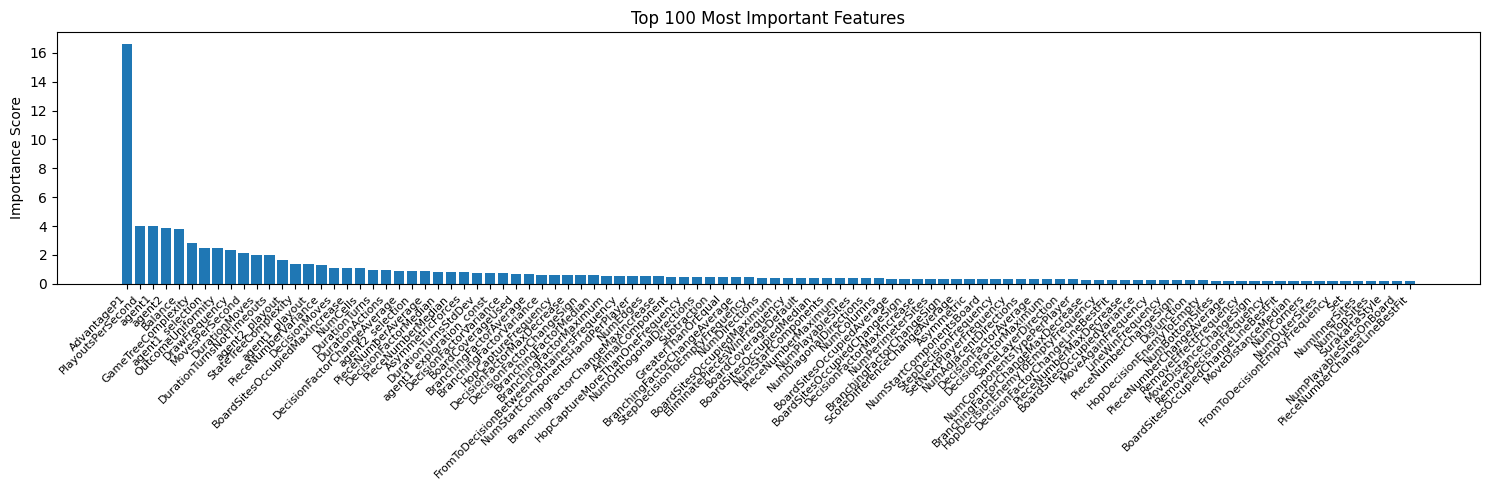

Fold 2 - RMSE: 0.3977534103496348
Fold 3


0:	learn: 0.6015457	test: 0.6086198	best: 0.6086198 (0)	total: 73.5ms	remaining: 3m 40s


50:	learn: 0.3811506	test: 0.4858631	best: 0.4858631 (50)	total: 4.06s	remaining: 3m 54s


100:	learn: 0.3408309	test: 0.4617153	best: 0.4617153 (100)	total: 8.31s	remaining: 3m 58s


150:	learn: 0.3186720	test: 0.4529600	best: 0.4529600 (150)	total: 12.5s	remaining: 3m 55s


200:	learn: 0.3041355	test: 0.4491265	best: 0.4491015 (198)	total: 16.7s	remaining: 3m 53s


250:	learn: 0.2931501	test: 0.4468538	best: 0.4468538 (250)	total: 21s	remaining: 3m 50s


300:	learn: 0.2842240	test: 0.4442237	best: 0.4442065 (299)	total: 25.2s	remaining: 3m 46s


350:	learn: 0.2764832	test: 0.4424811	best: 0.4424811 (350)	total: 29.5s	remaining: 3m 42s


400:	learn: 0.2695878	test: 0.4409474	best: 0.4409474 (400)	total: 33.7s	remaining: 3m 38s


450:	learn: 0.2637920	test: 0.4400528	best: 0.4400528 (450)	total: 38.1s	remaining: 3m 35s


500:	learn: 0.2585888	test: 0.4391736	best: 0.4391579 (499)	total: 42.5s	remaining: 3m 31s


550:	learn: 0.2538820	test: 0.4381400	best: 0.4381400 (550)	total: 46.7s	remaining: 3m 27s


600:	learn: 0.2494943	test: 0.4374895	best: 0.4374895 (600)	total: 51s	remaining: 3m 23s


650:	learn: 0.2455143	test: 0.4372224	best: 0.4372057 (645)	total: 55.4s	remaining: 3m 19s


700:	learn: 0.2416189	test: 0.4364676	best: 0.4364676 (700)	total: 59.7s	remaining: 3m 15s


750:	learn: 0.2382462	test: 0.4359683	best: 0.4359683 (750)	total: 1m 4s	remaining: 3m 11s


800:	learn: 0.2349109	test: 0.4356034	best: 0.4356034 (800)	total: 1m 8s	remaining: 3m 7s


850:	learn: 0.2318756	test: 0.4350928	best: 0.4350928 (850)	total: 1m 12s	remaining: 3m 3s


900:	learn: 0.2287960	test: 0.4346972	best: 0.4346972 (900)	total: 1m 16s	remaining: 2m 59s


950:	learn: 0.2260814	test: 0.4344700	best: 0.4344490 (935)	total: 1m 21s	remaining: 2m 54s


1000:	learn: 0.2234192	test: 0.4342051	best: 0.4342051 (1000)	total: 1m 25s	remaining: 2m 50s


1050:	learn: 0.2210080	test: 0.4339838	best: 0.4339774 (1048)	total: 1m 29s	remaining: 2m 46s


1100:	learn: 0.2186296	test: 0.4337572	best: 0.4337571 (1094)	total: 1m 34s	remaining: 2m 42s


1150:	learn: 0.2163808	test: 0.4335922	best: 0.4335922 (1150)	total: 1m 38s	remaining: 2m 38s


1200:	learn: 0.2143105	test: 0.4334636	best: 0.4334415 (1197)	total: 1m 42s	remaining: 2m 33s


1250:	learn: 0.2122777	test: 0.4333677	best: 0.4333354 (1244)	total: 1m 47s	remaining: 2m 29s


1300:	learn: 0.2102331	test: 0.4331833	best: 0.4331833 (1300)	total: 1m 51s	remaining: 2m 25s


1350:	learn: 0.2082853	test: 0.4329303	best: 0.4329284 (1348)	total: 1m 55s	remaining: 2m 21s


1400:	learn: 0.2065250	test: 0.4328646	best: 0.4328386 (1391)	total: 2m	remaining: 2m 16s


1450:	learn: 0.2047101	test: 0.4327598	best: 0.4327220 (1445)	total: 2m 4s	remaining: 2m 12s


1500:	learn: 0.2028514	test: 0.4326754	best: 0.4326652 (1488)	total: 2m 8s	remaining: 2m 8s


1550:	learn: 0.2011249	test: 0.4325366	best: 0.4325366 (1550)	total: 2m 13s	remaining: 2m 4s


1600:	learn: 0.1994579	test: 0.4324796	best: 0.4324634 (1592)	total: 2m 17s	remaining: 2m


1650:	learn: 0.1979235	test: 0.4324088	best: 0.4323931 (1636)	total: 2m 21s	remaining: 1m 55s


1700:	learn: 0.1962595	test: 0.4323096	best: 0.4322884 (1684)	total: 2m 26s	remaining: 1m 51s


1750:	learn: 0.1946039	test: 0.4322882	best: 0.4322383 (1743)	total: 2m 30s	remaining: 1m 47s


1800:	learn: 0.1930549	test: 0.4322471	best: 0.4322378 (1769)	total: 2m 34s	remaining: 1m 43s


1850:	learn: 0.1914389	test: 0.4321644	best: 0.4321581 (1839)	total: 2m 39s	remaining: 1m 38s


1900:	learn: 0.1900474	test: 0.4321826	best: 0.4321518 (1869)	total: 2m 43s	remaining: 1m 34s


1950:	learn: 0.1886449	test: 0.4320981	best: 0.4320981 (1950)	total: 2m 47s	remaining: 1m 30s


2000:	learn: 0.1871863	test: 0.4321073	best: 0.4320603 (1960)	total: 2m 52s	remaining: 1m 25s


2050:	learn: 0.1858362	test: 0.4319139	best: 0.4319139 (2050)	total: 2m 56s	remaining: 1m 21s


2100:	learn: 0.1844872	test: 0.4319009	best: 0.4318737 (2062)	total: 3m	remaining: 1m 17s


2150:	learn: 0.1831667	test: 0.4319476	best: 0.4318737 (2062)	total: 3m 5s	remaining: 1m 13s


2200:	learn: 0.1818545	test: 0.4319189	best: 0.4318737 (2062)	total: 3m 9s	remaining: 1m 8s


2250:	learn: 0.1805388	test: 0.4319073	best: 0.4318737 (2062)	total: 3m 13s	remaining: 1m 4s


2300:	learn: 0.1791871	test: 0.4318401	best: 0.4318178 (2283)	total: 3m 18s	remaining: 1m


2350:	learn: 0.1779465	test: 0.4318846	best: 0.4318178 (2283)	total: 3m 22s	remaining: 55.9s


2400:	learn: 0.1767227	test: 0.4318439	best: 0.4318178 (2283)	total: 3m 26s	remaining: 51.6s


2450:	learn: 0.1755187	test: 0.4318633	best: 0.4318178 (2283)	total: 3m 31s	remaining: 47.3s


2500:	learn: 0.1742436	test: 0.4318173	best: 0.4318157 (2497)	total: 3m 35s	remaining: 43s


2550:	learn: 0.1730666	test: 0.4318056	best: 0.4318056 (2550)	total: 3m 39s	remaining: 38.7s


2600:	learn: 0.1718931	test: 0.4318412	best: 0.4318014 (2558)	total: 3m 44s	remaining: 34.4s


2650:	learn: 0.1707022	test: 0.4318128	best: 0.4318014 (2558)	total: 3m 48s	remaining: 30.1s


2700:	learn: 0.1696200	test: 0.4317737	best: 0.4317563 (2670)	total: 3m 52s	remaining: 25.8s


2750:	learn: 0.1685041	test: 0.4317760	best: 0.4317563 (2670)	total: 3m 57s	remaining: 21.5s


2800:	learn: 0.1673444	test: 0.4317632	best: 0.4317520 (2771)	total: 4m 1s	remaining: 17.2s


2850:	learn: 0.1663473	test: 0.4317655	best: 0.4317495 (2843)	total: 4m 5s	remaining: 12.8s


2900:	learn: 0.1652640	test: 0.4317506	best: 0.4317374 (2876)	total: 4m 10s	remaining: 8.54s


2950:	learn: 0.1640901	test: 0.4317403	best: 0.4316992 (2941)	total: 4m 14s	remaining: 4.22s


2999:	learn: 0.1630990	test: 0.4317984	best: 0.4316992 (2941)	total: 4m 18s	remaining: 0us

bestTest = 0.4316992229
bestIteration = 2941

Shrink model to first 2942 iterations.


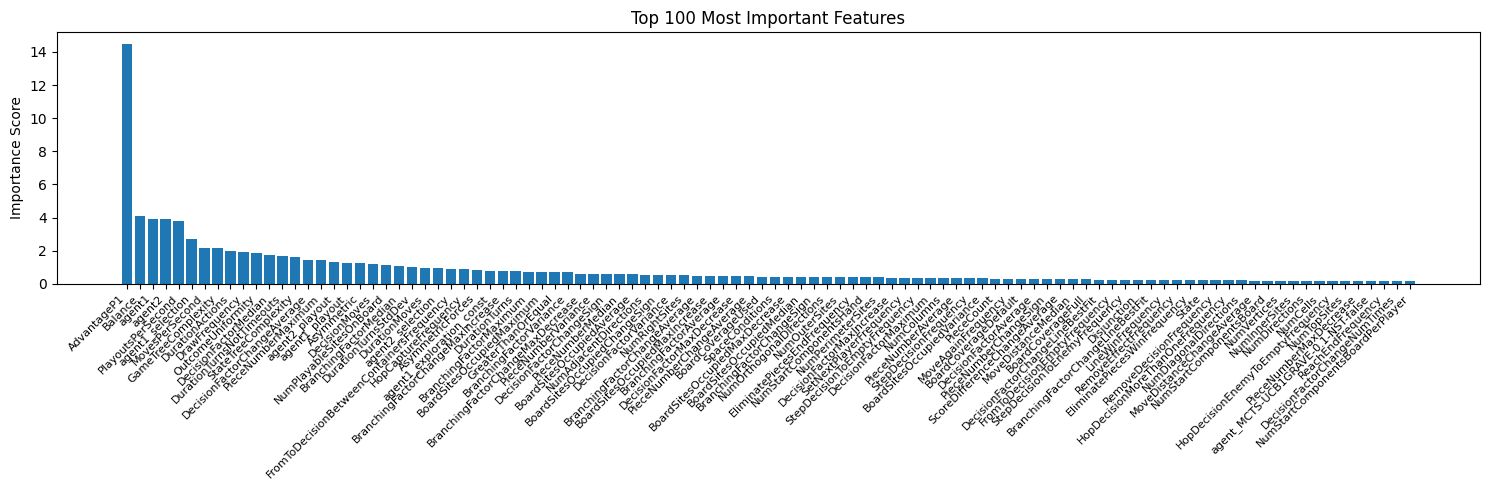

Fold 3 - RMSE: 0.4310258466858804
Fold 4


0:	learn: 0.6032699	test: 0.5983320	best: 0.5983320 (0)	total: 79ms	remaining: 3m 56s


50:	learn: 0.3857321	test: 0.4819399	best: 0.4819399 (50)	total: 4.17s	remaining: 4m 1s


100:	learn: 0.3475504	test: 0.4640716	best: 0.4640716 (100)	total: 8.5s	remaining: 4m 3s


150:	learn: 0.3255891	test: 0.4561707	best: 0.4561707 (150)	total: 12.7s	remaining: 4m


200:	learn: 0.3111673	test: 0.4517809	best: 0.4517809 (200)	total: 17.1s	remaining: 3m 58s


250:	learn: 0.2999018	test: 0.4505090	best: 0.4503940 (248)	total: 21.5s	remaining: 3m 55s


300:	learn: 0.2907304	test: 0.4484506	best: 0.4484506 (300)	total: 25.9s	remaining: 3m 52s


350:	learn: 0.2833601	test: 0.4470731	best: 0.4469987 (347)	total: 30.4s	remaining: 3m 49s


400:	learn: 0.2762040	test: 0.4460916	best: 0.4459941 (399)	total: 34.7s	remaining: 3m 45s


450:	learn: 0.2701766	test: 0.4455565	best: 0.4455287 (448)	total: 39.2s	remaining: 3m 41s


500:	learn: 0.2648141	test: 0.4450691	best: 0.4450691 (500)	total: 43.7s	remaining: 3m 37s


550:	learn: 0.2602480	test: 0.4447061	best: 0.4446950 (547)	total: 48.1s	remaining: 3m 33s


600:	learn: 0.2561399	test: 0.4443649	best: 0.4443378 (594)	total: 52.5s	remaining: 3m 29s


650:	learn: 0.2518931	test: 0.4441775	best: 0.4441473 (646)	total: 57s	remaining: 3m 25s


700:	learn: 0.2483428	test: 0.4438885	best: 0.4438454 (691)	total: 1m 1s	remaining: 3m 21s


750:	learn: 0.2445776	test: 0.4437187	best: 0.4436653 (740)	total: 1m 5s	remaining: 3m 16s


800:	learn: 0.2411758	test: 0.4433522	best: 0.4433522 (800)	total: 1m 10s	remaining: 3m 12s


850:	learn: 0.2378321	test: 0.4431199	best: 0.4430969 (848)	total: 1m 14s	remaining: 3m 8s


900:	learn: 0.2348973	test: 0.4427659	best: 0.4427659 (900)	total: 1m 19s	remaining: 3m 4s


950:	learn: 0.2323688	test: 0.4424683	best: 0.4424659 (949)	total: 1m 23s	remaining: 2m 59s


1000:	learn: 0.2295553	test: 0.4421435	best: 0.4421050 (977)	total: 1m 27s	remaining: 2m 55s


1050:	learn: 0.2269984	test: 0.4418246	best: 0.4418246 (1050)	total: 1m 32s	remaining: 2m 51s


1100:	learn: 0.2247483	test: 0.4414477	best: 0.4414300 (1099)	total: 1m 36s	remaining: 2m 47s


1150:	learn: 0.2224833	test: 0.4414475	best: 0.4414300 (1099)	total: 1m 41s	remaining: 2m 42s


1200:	learn: 0.2201385	test: 0.4412943	best: 0.4412943 (1200)	total: 1m 45s	remaining: 2m 38s


1250:	learn: 0.2179997	test: 0.4412585	best: 0.4412568 (1236)	total: 1m 50s	remaining: 2m 34s


1300:	learn: 0.2159195	test: 0.4412876	best: 0.4412412 (1262)	total: 1m 54s	remaining: 2m 29s


1350:	learn: 0.2138112	test: 0.4411571	best: 0.4411205 (1332)	total: 1m 59s	remaining: 2m 25s


1400:	learn: 0.2118652	test: 0.4411816	best: 0.4411205 (1332)	total: 2m 3s	remaining: 2m 20s


1450:	learn: 0.2099369	test: 0.4411458	best: 0.4411194 (1441)	total: 2m 7s	remaining: 2m 16s


1500:	learn: 0.2080768	test: 0.4411661	best: 0.4410792 (1479)	total: 2m 12s	remaining: 2m 12s


1550:	learn: 0.2062800	test: 0.4410722	best: 0.4410210 (1544)	total: 2m 16s	remaining: 2m 7s


1600:	learn: 0.2044656	test: 0.4410987	best: 0.4409900 (1578)	total: 2m 21s	remaining: 2m 3s


1650:	learn: 0.2027325	test: 0.4410010	best: 0.4409900 (1578)	total: 2m 25s	remaining: 1m 58s


1700:	learn: 0.2009890	test: 0.4409804	best: 0.4409529 (1679)	total: 2m 30s	remaining: 1m 54s


1750:	learn: 0.1993857	test: 0.4410108	best: 0.4408932 (1716)	total: 2m 34s	remaining: 1m 50s


1800:	learn: 0.1977437	test: 0.4409439	best: 0.4408932 (1716)	total: 2m 38s	remaining: 1m 45s


1850:	learn: 0.1962245	test: 0.4408613	best: 0.4408519 (1846)	total: 2m 43s	remaining: 1m 41s


1900:	learn: 0.1945457	test: 0.4407562	best: 0.4407518 (1892)	total: 2m 47s	remaining: 1m 36s


1950:	learn: 0.1929308	test: 0.4407212	best: 0.4406571 (1933)	total: 2m 52s	remaining: 1m 32s


2000:	learn: 0.1912934	test: 0.4407125	best: 0.4406571 (1933)	total: 2m 56s	remaining: 1m 28s


2050:	learn: 0.1898130	test: 0.4406009	best: 0.4406009 (2050)	total: 3m	remaining: 1m 23s


2100:	learn: 0.1884521	test: 0.4405344	best: 0.4405334 (2099)	total: 3m 5s	remaining: 1m 19s


2150:	learn: 0.1870470	test: 0.4404127	best: 0.4404089 (2145)	total: 3m 9s	remaining: 1m 14s


2200:	learn: 0.1856576	test: 0.4403002	best: 0.4402791 (2198)	total: 3m 14s	remaining: 1m 10s


2250:	learn: 0.1843564	test: 0.4403453	best: 0.4402791 (2198)	total: 3m 18s	remaining: 1m 6s


2300:	learn: 0.1829606	test: 0.4403749	best: 0.4402791 (2198)	total: 3m 23s	remaining: 1m 1s


2350:	learn: 0.1816839	test: 0.4403165	best: 0.4402791 (2198)	total: 3m 27s	remaining: 57.4s


2400:	learn: 0.1803214	test: 0.4403004	best: 0.4402791 (2198)	total: 3m 32s	remaining: 53s


2450:	learn: 0.1791396	test: 0.4403084	best: 0.4402676 (2406)	total: 3m 36s	remaining: 48.6s


2500:	learn: 0.1778770	test: 0.4403043	best: 0.4402676 (2406)	total: 3m 41s	remaining: 44.1s


2550:	learn: 0.1765544	test: 0.4403477	best: 0.4402676 (2406)	total: 3m 45s	remaining: 39.7s


2600:	learn: 0.1754046	test: 0.4403443	best: 0.4402676 (2406)	total: 3m 50s	remaining: 35.3s


2650:	learn: 0.1742654	test: 0.4403931	best: 0.4402676 (2406)	total: 3m 54s	remaining: 30.9s


2700:	learn: 0.1730786	test: 0.4403563	best: 0.4402676 (2406)	total: 3m 59s	remaining: 26.5s


2750:	learn: 0.1719338	test: 0.4403413	best: 0.4402676 (2406)	total: 4m 3s	remaining: 22.1s


2800:	learn: 0.1708104	test: 0.4403098	best: 0.4402676 (2406)	total: 4m 8s	remaining: 17.6s


2850:	learn: 0.1698348	test: 0.4403178	best: 0.4402676 (2406)	total: 4m 12s	remaining: 13.2s


2900:	learn: 0.1687862	test: 0.4402742	best: 0.4402676 (2406)	total: 4m 17s	remaining: 8.78s


2950:	learn: 0.1677362	test: 0.4402972	best: 0.4402676 (2406)	total: 4m 21s	remaining: 4.35s


2999:	learn: 0.1666451	test: 0.4402123	best: 0.4402123 (2999)	total: 4m 26s	remaining: 0us

bestTest = 0.4402122948
bestIteration = 2999



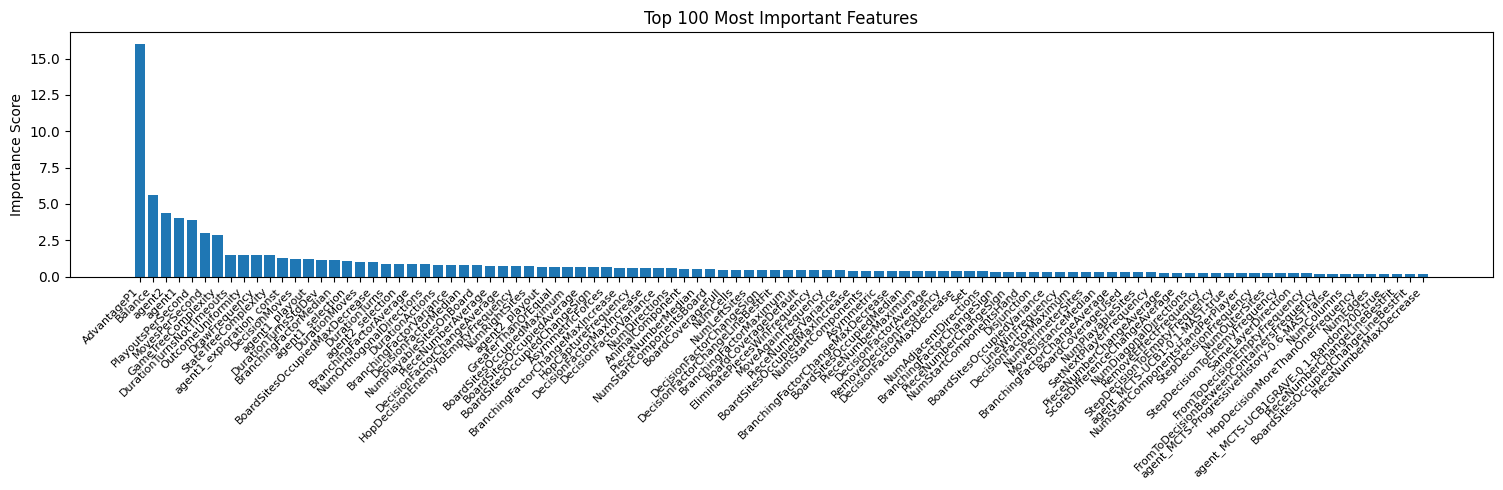

Fold 4 - RMSE: 0.439645281246648
Fold 5


0:	learn: 0.6049648	test: 0.5842912	best: 0.5842912 (0)	total: 71.4ms	remaining: 3m 34s


50:	learn: 0.3822427	test: 0.4853699	best: 0.4853699 (50)	total: 4.11s	remaining: 3m 57s


100:	learn: 0.3447909	test: 0.4666649	best: 0.4666649 (100)	total: 8.45s	remaining: 4m 2s


150:	learn: 0.3227584	test: 0.4598980	best: 0.4598980 (150)	total: 12.8s	remaining: 4m


200:	learn: 0.3086882	test: 0.4551781	best: 0.4551781 (200)	total: 17.1s	remaining: 3m 58s


250:	learn: 0.2973944	test: 0.4514772	best: 0.4514772 (250)	total: 21.5s	remaining: 3m 55s


300:	learn: 0.2881205	test: 0.4487778	best: 0.4487778 (300)	total: 25.9s	remaining: 3m 52s


350:	learn: 0.2803861	test: 0.4472662	best: 0.4472646 (349)	total: 30.2s	remaining: 3m 47s


400:	learn: 0.2735091	test: 0.4461752	best: 0.4461752 (400)	total: 34.5s	remaining: 3m 43s


450:	learn: 0.2673794	test: 0.4449973	best: 0.4449973 (450)	total: 38.8s	remaining: 3m 39s


500:	learn: 0.2621092	test: 0.4440494	best: 0.4440324 (496)	total: 43.1s	remaining: 3m 35s


550:	learn: 0.2569842	test: 0.4434649	best: 0.4434649 (550)	total: 47.4s	remaining: 3m 30s


600:	learn: 0.2526754	test: 0.4427809	best: 0.4427778 (595)	total: 51.8s	remaining: 3m 26s


650:	learn: 0.2485966	test: 0.4422145	best: 0.4422145 (650)	total: 56.1s	remaining: 3m 22s


700:	learn: 0.2446166	test: 0.4417093	best: 0.4417093 (700)	total: 1m	remaining: 3m 18s


750:	learn: 0.2413052	test: 0.4413066	best: 0.4413066 (750)	total: 1m 4s	remaining: 3m 14s


800:	learn: 0.2380616	test: 0.4411052	best: 0.4411019 (791)	total: 1m 9s	remaining: 3m 10s


850:	learn: 0.2352822	test: 0.4409494	best: 0.4409494 (850)	total: 1m 13s	remaining: 3m 5s


900:	learn: 0.2325294	test: 0.4407374	best: 0.4407374 (900)	total: 1m 18s	remaining: 3m 1s


950:	learn: 0.2298023	test: 0.4406096	best: 0.4405645 (940)	total: 1m 22s	remaining: 2m 57s


1000:	learn: 0.2272468	test: 0.4402663	best: 0.4402663 (1000)	total: 1m 26s	remaining: 2m 53s


1050:	learn: 0.2247680	test: 0.4401322	best: 0.4401322 (1050)	total: 1m 31s	remaining: 2m 49s


1100:	learn: 0.2224769	test: 0.4400083	best: 0.4399932 (1096)	total: 1m 35s	remaining: 2m 45s


1150:	learn: 0.2201904	test: 0.4399494	best: 0.4399494 (1150)	total: 1m 40s	remaining: 2m 40s


1200:	learn: 0.2177952	test: 0.4398017	best: 0.4397784 (1195)	total: 1m 44s	remaining: 2m 36s


1250:	learn: 0.2156061	test: 0.4397620	best: 0.4397204 (1226)	total: 1m 48s	remaining: 2m 32s


1300:	learn: 0.2134977	test: 0.4395156	best: 0.4395156 (1300)	total: 1m 53s	remaining: 2m 27s


1350:	learn: 0.2114929	test: 0.4393251	best: 0.4393251 (1350)	total: 1m 57s	remaining: 2m 23s


1400:	learn: 0.2096611	test: 0.4393789	best: 0.4393207 (1357)	total: 2m 1s	remaining: 2m 19s


1450:	learn: 0.2077895	test: 0.4394018	best: 0.4393207 (1357)	total: 2m 6s	remaining: 2m 14s


1500:	learn: 0.2059485	test: 0.4393569	best: 0.4393207 (1357)	total: 2m 10s	remaining: 2m 10s


1550:	learn: 0.2041077	test: 0.4393304	best: 0.4393066 (1545)	total: 2m 15s	remaining: 2m 6s


1600:	learn: 0.2023559	test: 0.4392021	best: 0.4392016 (1598)	total: 2m 19s	remaining: 2m 1s


1650:	learn: 0.2008361	test: 0.4391820	best: 0.4391586 (1609)	total: 2m 23s	remaining: 1m 57s


1700:	learn: 0.1992981	test: 0.4390861	best: 0.4390749 (1696)	total: 2m 28s	remaining: 1m 53s


1750:	learn: 0.1977535	test: 0.4390347	best: 0.4390196 (1748)	total: 2m 32s	remaining: 1m 48s


1800:	learn: 0.1961699	test: 0.4390186	best: 0.4389774 (1790)	total: 2m 36s	remaining: 1m 44s


1850:	learn: 0.1946216	test: 0.4390378	best: 0.4389774 (1790)	total: 2m 41s	remaining: 1m 40s


1900:	learn: 0.1931404	test: 0.4389315	best: 0.4389282 (1898)	total: 2m 45s	remaining: 1m 35s


1950:	learn: 0.1916626	test: 0.4388983	best: 0.4388661 (1944)	total: 2m 50s	remaining: 1m 31s


2000:	learn: 0.1902487	test: 0.4388691	best: 0.4388611 (1997)	total: 2m 54s	remaining: 1m 27s


2050:	learn: 0.1888868	test: 0.4387781	best: 0.4387466 (2042)	total: 2m 59s	remaining: 1m 22s


2100:	learn: 0.1876067	test: 0.4387613	best: 0.4387283 (2059)	total: 3m 3s	remaining: 1m 18s


2150:	learn: 0.1862883	test: 0.4387508	best: 0.4387283 (2059)	total: 3m 7s	remaining: 1m 14s


2200:	learn: 0.1849679	test: 0.4387197	best: 0.4387015 (2170)	total: 3m 12s	remaining: 1m 9s


2250:	learn: 0.1836670	test: 0.4386563	best: 0.4386473 (2249)	total: 3m 16s	remaining: 1m 5s


2300:	learn: 0.1823166	test: 0.4386446	best: 0.4386220 (2286)	total: 3m 21s	remaining: 1m 1s


2350:	learn: 0.1810497	test: 0.4385818	best: 0.4385818 (2350)	total: 3m 25s	remaining: 56.7s


2400:	learn: 0.1798193	test: 0.4385598	best: 0.4385396 (2395)	total: 3m 29s	remaining: 52.4s


2450:	learn: 0.1785969	test: 0.4385678	best: 0.4385367 (2402)	total: 3m 34s	remaining: 48s


2500:	learn: 0.1773311	test: 0.4385840	best: 0.4385367 (2402)	total: 3m 38s	remaining: 43.6s


2550:	learn: 0.1761632	test: 0.4385758	best: 0.4385367 (2402)	total: 3m 42s	remaining: 39.2s


2600:	learn: 0.1750900	test: 0.4386244	best: 0.4385367 (2402)	total: 3m 47s	remaining: 34.9s


2650:	learn: 0.1740460	test: 0.4385517	best: 0.4385367 (2402)	total: 3m 51s	remaining: 30.5s


2700:	learn: 0.1729121	test: 0.4385229	best: 0.4385110 (2699)	total: 3m 56s	remaining: 26.2s


2750:	learn: 0.1718456	test: 0.4385135	best: 0.4384948 (2708)	total: 4m	remaining: 21.8s


2800:	learn: 0.1707403	test: 0.4384913	best: 0.4384828 (2788)	total: 4m 5s	remaining: 17.4s


2850:	learn: 0.1697024	test: 0.4385220	best: 0.4384634 (2824)	total: 4m 9s	remaining: 13s


2900:	learn: 0.1686647	test: 0.4384892	best: 0.4384634 (2824)	total: 4m 13s	remaining: 8.67s


2950:	learn: 0.1676343	test: 0.4384681	best: 0.4384629 (2948)	total: 4m 18s	remaining: 4.29s


2999:	learn: 0.1666811	test: 0.4384939	best: 0.4384629 (2948)	total: 4m 22s	remaining: 0us

bestTest = 0.4384628514
bestIteration = 2948

Shrink model to first 2949 iterations.


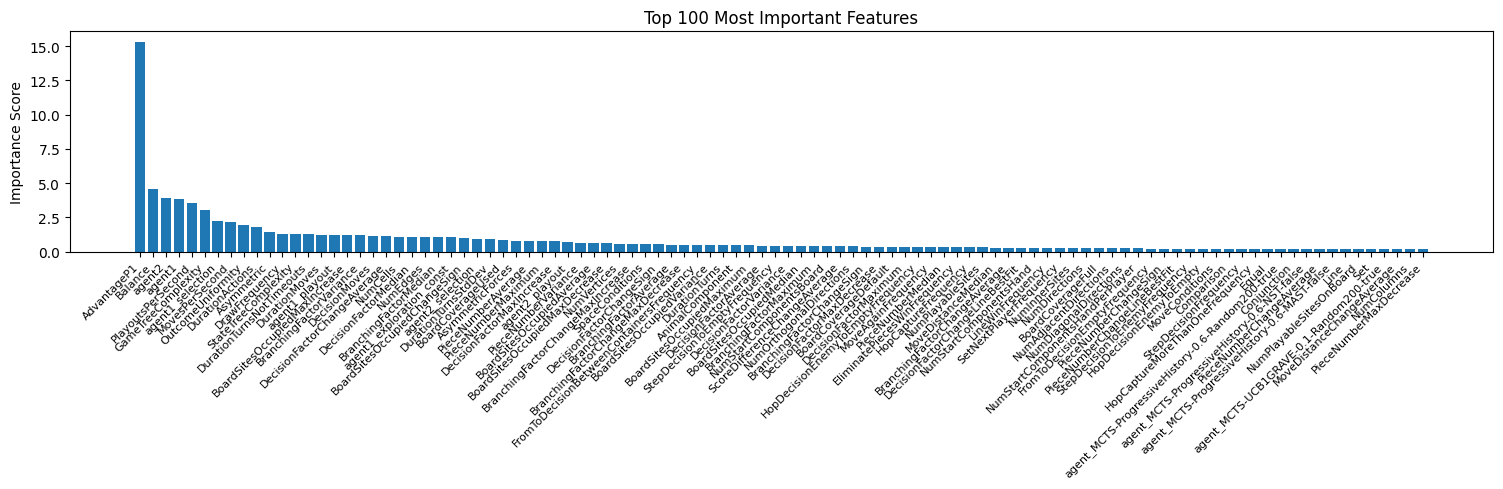

Fold 5 - RMSE: 0.43771520304720807
List of oof scores: [0.40700443680379966, 0.3977534103496348, 0.4310258466858804, 0.439645281246648, 0.43771520304720807]
Average oof score: 0.4226288356266342


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6090838	test: 0.5710242	best: 0.5710242 (0)	total: 66.4ms	remaining: 3m 19s


50:	learn: 0.3876980	test: 0.4673279	best: 0.4673279 (50)	total: 4.15s	remaining: 3m 59s


100:	learn: 0.3483378	test: 0.4532105	best: 0.4532105 (100)	total: 8.48s	remaining: 4m 3s


150:	learn: 0.3243138	test: 0.4463907	best: 0.4463907 (150)	total: 12.7s	remaining: 3m 58s


200:	learn: 0.3101636	test: 0.4427283	best: 0.4427283 (200)	total: 16.9s	remaining: 3m 55s


250:	learn: 0.2982900	test: 0.4400425	best: 0.4397121 (246)	total: 21.2s	remaining: 3m 52s


300:	learn: 0.2889772	test: 0.4381956	best: 0.4381581 (295)	total: 25.6s	remaining: 3m 49s


350:	learn: 0.2813415	test: 0.4376280	best: 0.4376254 (348)	total: 29.9s	remaining: 3m 45s


400:	learn: 0.2743872	test: 0.4367376	best: 0.4366995 (399)	total: 34.2s	remaining: 3m 41s


450:	learn: 0.2682608	test: 0.4360743	best: 0.4360743 (450)	total: 38.5s	remaining: 3m 37s


500:	learn: 0.2626192	test: 0.4352932	best: 0.4352739 (499)	total: 42.8s	remaining: 3m 33s


550:	learn: 0.2573991	test: 0.4345043	best: 0.4344813 (549)	total: 47.1s	remaining: 3m 29s


600:	learn: 0.2530140	test: 0.4341594	best: 0.4341594 (600)	total: 51.4s	remaining: 3m 25s


650:	learn: 0.2488238	test: 0.4336551	best: 0.4336551 (650)	total: 55.7s	remaining: 3m 21s


700:	learn: 0.2450157	test: 0.4335859	best: 0.4335477 (697)	total: 60s	remaining: 3m 16s


750:	learn: 0.2413055	test: 0.4333082	best: 0.4332192 (741)	total: 1m 4s	remaining: 3m 12s


800:	learn: 0.2377944	test: 0.4329199	best: 0.4329042 (798)	total: 1m 8s	remaining: 3m 8s


850:	learn: 0.2348818	test: 0.4326107	best: 0.4326107 (850)	total: 1m 13s	remaining: 3m 4s


900:	learn: 0.2321534	test: 0.4326237	best: 0.4326107 (850)	total: 1m 17s	remaining: 3m


950:	learn: 0.2293359	test: 0.4325171	best: 0.4325168 (949)	total: 1m 21s	remaining: 2m 56s


1000:	learn: 0.2266855	test: 0.4322633	best: 0.4322633 (1000)	total: 1m 26s	remaining: 2m 52s


1050:	learn: 0.2240056	test: 0.4319872	best: 0.4319865 (1049)	total: 1m 30s	remaining: 2m 47s


1100:	learn: 0.2214558	test: 0.4319060	best: 0.4319017 (1096)	total: 1m 34s	remaining: 2m 43s


1150:	learn: 0.2191373	test: 0.4317434	best: 0.4317434 (1150)	total: 1m 39s	remaining: 2m 39s


1200:	learn: 0.2168998	test: 0.4316177	best: 0.4315986 (1192)	total: 1m 43s	remaining: 2m 34s


1250:	learn: 0.2147267	test: 0.4315078	best: 0.4314781 (1246)	total: 1m 47s	remaining: 2m 30s


1300:	learn: 0.2125915	test: 0.4314274	best: 0.4314274 (1300)	total: 1m 52s	remaining: 2m 26s


1350:	learn: 0.2106283	test: 0.4314380	best: 0.4314256 (1305)	total: 1m 56s	remaining: 2m 22s


1400:	learn: 0.2087701	test: 0.4314348	best: 0.4313969 (1362)	total: 2m	remaining: 2m 17s


1450:	learn: 0.2070036	test: 0.4314068	best: 0.4313959 (1411)	total: 2m 5s	remaining: 2m 13s


1500:	learn: 0.2052591	test: 0.4313397	best: 0.4313214 (1499)	total: 2m 9s	remaining: 2m 9s


1550:	learn: 0.2035086	test: 0.4313856	best: 0.4313214 (1499)	total: 2m 13s	remaining: 2m 5s


1600:	learn: 0.2017709	test: 0.4313046	best: 0.4312996 (1599)	total: 2m 18s	remaining: 2m


1650:	learn: 0.1999940	test: 0.4313081	best: 0.4312772 (1613)	total: 2m 22s	remaining: 1m 56s


1700:	learn: 0.1983475	test: 0.4312569	best: 0.4312440 (1697)	total: 2m 26s	remaining: 1m 52s


1750:	learn: 0.1967753	test: 0.4312301	best: 0.4312041 (1733)	total: 2m 31s	remaining: 1m 47s


1800:	learn: 0.1952732	test: 0.4312034	best: 0.4311702 (1781)	total: 2m 35s	remaining: 1m 43s


1850:	learn: 0.1937567	test: 0.4311580	best: 0.4311234 (1838)	total: 2m 39s	remaining: 1m 39s


1900:	learn: 0.1924077	test: 0.4310866	best: 0.4310866 (1900)	total: 2m 44s	remaining: 1m 35s


1950:	learn: 0.1910733	test: 0.4311119	best: 0.4310692 (1903)	total: 2m 48s	remaining: 1m 30s


2000:	learn: 0.1896489	test: 0.4310338	best: 0.4310229 (1974)	total: 2m 53s	remaining: 1m 26s


2050:	learn: 0.1883269	test: 0.4310821	best: 0.4310229 (1974)	total: 2m 57s	remaining: 1m 22s


2100:	learn: 0.1869643	test: 0.4310585	best: 0.4310229 (1974)	total: 3m 1s	remaining: 1m 17s


2150:	learn: 0.1856791	test: 0.4310700	best: 0.4310229 (1974)	total: 3m 6s	remaining: 1m 13s


2200:	learn: 0.1843815	test: 0.4309849	best: 0.4309635 (2189)	total: 3m 10s	remaining: 1m 9s


2250:	learn: 0.1831360	test: 0.4309097	best: 0.4308950 (2233)	total: 3m 15s	remaining: 1m 4s


2300:	learn: 0.1819504	test: 0.4309073	best: 0.4308759 (2256)	total: 3m 19s	remaining: 1m


2350:	learn: 0.1808530	test: 0.4309825	best: 0.4308759 (2256)	total: 3m 23s	remaining: 56.3s


2400:	learn: 0.1796716	test: 0.4309419	best: 0.4308759 (2256)	total: 3m 28s	remaining: 52s


2450:	learn: 0.1785110	test: 0.4309447	best: 0.4308759 (2256)	total: 3m 32s	remaining: 47.6s


2500:	learn: 0.1773490	test: 0.4309733	best: 0.4308759 (2256)	total: 3m 37s	remaining: 43.3s


2550:	learn: 0.1761396	test: 0.4309982	best: 0.4308759 (2256)	total: 3m 41s	remaining: 39s


2600:	learn: 0.1750160	test: 0.4309962	best: 0.4308759 (2256)	total: 3m 45s	remaining: 34.7s


2650:	learn: 0.1738705	test: 0.4309897	best: 0.4308759 (2256)	total: 3m 50s	remaining: 30.3s


2700:	learn: 0.1726643	test: 0.4310011	best: 0.4308759 (2256)	total: 3m 54s	remaining: 26s


2750:	learn: 0.1715041	test: 0.4310691	best: 0.4308759 (2256)	total: 3m 59s	remaining: 21.6s


2800:	learn: 0.1703370	test: 0.4310459	best: 0.4308759 (2256)	total: 4m 3s	remaining: 17.3s


2850:	learn: 0.1692690	test: 0.4310519	best: 0.4308759 (2256)	total: 4m 7s	remaining: 12.9s


2900:	learn: 0.1682418	test: 0.4310642	best: 0.4308759 (2256)	total: 4m 12s	remaining: 8.61s


2950:	learn: 0.1672083	test: 0.4310977	best: 0.4308759 (2256)	total: 4m 16s	remaining: 4.26s


2999:	learn: 0.1661892	test: 0.4311236	best: 0.4308759 (2256)	total: 4m 20s	remaining: 0us

bestTest = 0.4308759498
bestIteration = 2256

Shrink model to first 2257 iterations.


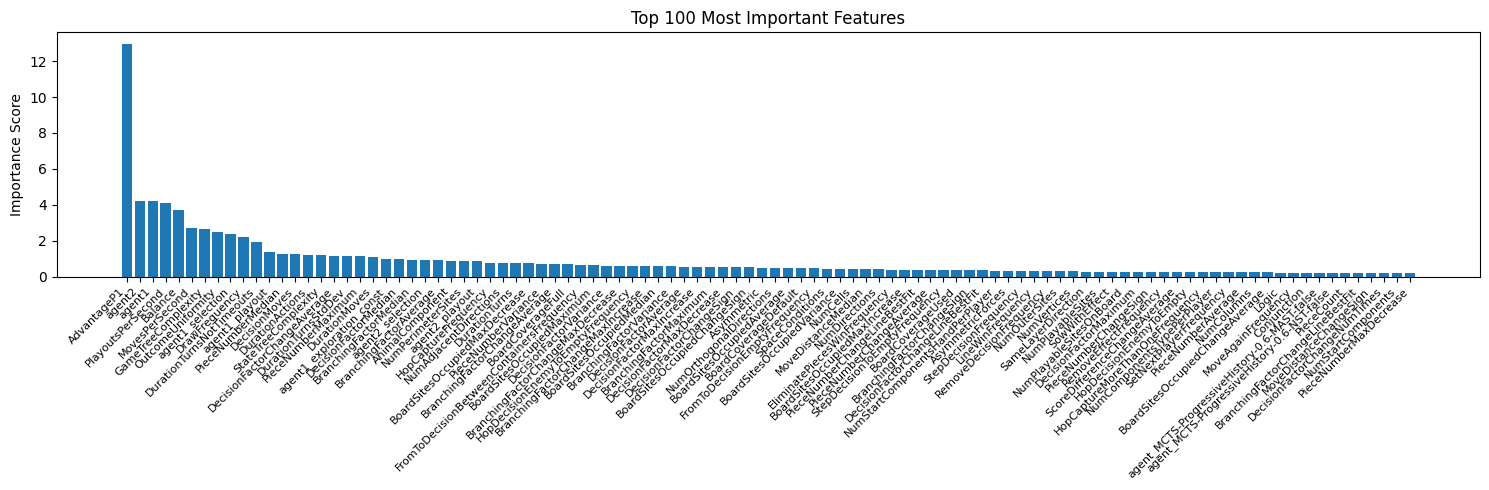

Fold 1 - RMSE: 0.43038962311358264
Fold 2


0:	learn: 0.6053650	test: 0.5693396	best: 0.5693396 (0)	total: 80ms	remaining: 3m 59s


50:	learn: 0.3856847	test: 0.4618539	best: 0.4618539 (50)	total: 4.16s	remaining: 4m


100:	learn: 0.3467419	test: 0.4403016	best: 0.4403016 (100)	total: 8.55s	remaining: 4m 5s


150:	learn: 0.3242549	test: 0.4313656	best: 0.4313656 (150)	total: 12.8s	remaining: 4m


200:	learn: 0.3091660	test: 0.4268414	best: 0.4268414 (200)	total: 17.1s	remaining: 3m 58s


250:	learn: 0.2976577	test: 0.4239845	best: 0.4239845 (250)	total: 21.5s	remaining: 3m 55s


300:	learn: 0.2885835	test: 0.4215284	best: 0.4215086 (299)	total: 25.9s	remaining: 3m 52s


350:	learn: 0.2800625	test: 0.4193192	best: 0.4193192 (350)	total: 30.2s	remaining: 3m 48s


400:	learn: 0.2734208	test: 0.4178612	best: 0.4178612 (400)	total: 34.6s	remaining: 3m 44s


450:	learn: 0.2676092	test: 0.4167087	best: 0.4166811 (447)	total: 39s	remaining: 3m 40s


500:	learn: 0.2620887	test: 0.4159907	best: 0.4159907 (500)	total: 43.3s	remaining: 3m 35s


550:	learn: 0.2571265	test: 0.4157120	best: 0.4156510 (538)	total: 47.6s	remaining: 3m 31s


600:	learn: 0.2526411	test: 0.4152079	best: 0.4152079 (600)	total: 52s	remaining: 3m 27s


650:	learn: 0.2485988	test: 0.4146559	best: 0.4146559 (650)	total: 56.4s	remaining: 3m 23s


700:	learn: 0.2447929	test: 0.4143155	best: 0.4143155 (700)	total: 1m	remaining: 3m 19s


750:	learn: 0.2412944	test: 0.4137266	best: 0.4137266 (750)	total: 1m 5s	remaining: 3m 14s


800:	learn: 0.2380181	test: 0.4133243	best: 0.4132860 (795)	total: 1m 9s	remaining: 3m 10s


850:	learn: 0.2350656	test: 0.4130460	best: 0.4130283 (841)	total: 1m 13s	remaining: 3m 6s


900:	learn: 0.2324211	test: 0.4126364	best: 0.4126364 (900)	total: 1m 18s	remaining: 3m 1s


950:	learn: 0.2298707	test: 0.4124433	best: 0.4124433 (950)	total: 1m 22s	remaining: 2m 57s


1000:	learn: 0.2270689	test: 0.4121123	best: 0.4121003 (998)	total: 1m 26s	remaining: 2m 53s


1050:	learn: 0.2246302	test: 0.4120445	best: 0.4119203 (1025)	total: 1m 31s	remaining: 2m 49s


1100:	learn: 0.2225146	test: 0.4118680	best: 0.4118341 (1091)	total: 1m 35s	remaining: 2m 45s


1150:	learn: 0.2200992	test: 0.4115991	best: 0.4115673 (1145)	total: 1m 40s	remaining: 2m 40s


1200:	learn: 0.2177766	test: 0.4113620	best: 0.4113620 (1200)	total: 1m 44s	remaining: 2m 36s


1250:	learn: 0.2157015	test: 0.4112629	best: 0.4112247 (1245)	total: 1m 48s	remaining: 2m 32s


1300:	learn: 0.2137382	test: 0.4112415	best: 0.4112247 (1245)	total: 1m 53s	remaining: 2m 28s


1350:	learn: 0.2116290	test: 0.4110605	best: 0.4110605 (1350)	total: 1m 57s	remaining: 2m 23s


1400:	learn: 0.2096712	test: 0.4108705	best: 0.4108635 (1398)	total: 2m 2s	remaining: 2m 19s


1450:	learn: 0.2078245	test: 0.4108001	best: 0.4108001 (1450)	total: 2m 6s	remaining: 2m 15s


1500:	learn: 0.2061238	test: 0.4106361	best: 0.4106303 (1495)	total: 2m 11s	remaining: 2m 10s


1550:	learn: 0.2042641	test: 0.4104855	best: 0.4104855 (1550)	total: 2m 15s	remaining: 2m 6s


1600:	learn: 0.2024671	test: 0.4104971	best: 0.4104685 (1579)	total: 2m 19s	remaining: 2m 2s


1650:	learn: 0.2008077	test: 0.4104539	best: 0.4104335 (1630)	total: 2m 24s	remaining: 1m 57s


1700:	learn: 0.1993277	test: 0.4103404	best: 0.4103339 (1698)	total: 2m 28s	remaining: 1m 53s


1750:	learn: 0.1978195	test: 0.4102845	best: 0.4102792 (1747)	total: 2m 33s	remaining: 1m 49s


1800:	learn: 0.1962722	test: 0.4102233	best: 0.4102059 (1794)	total: 2m 37s	remaining: 1m 45s


1850:	learn: 0.1947811	test: 0.4101097	best: 0.4100985 (1848)	total: 2m 42s	remaining: 1m 40s


1900:	learn: 0.1933165	test: 0.4101274	best: 0.4100807 (1874)	total: 2m 46s	remaining: 1m 36s


1950:	learn: 0.1917770	test: 0.4100632	best: 0.4100632 (1950)	total: 2m 51s	remaining: 1m 31s


2000:	learn: 0.1904715	test: 0.4100557	best: 0.4100362 (1952)	total: 2m 55s	remaining: 1m 27s


2050:	learn: 0.1891098	test: 0.4101401	best: 0.4100362 (1952)	total: 2m 59s	remaining: 1m 23s


2100:	learn: 0.1876946	test: 0.4101348	best: 0.4100362 (1952)	total: 3m 4s	remaining: 1m 18s


2150:	learn: 0.1864245	test: 0.4100924	best: 0.4100362 (1952)	total: 3m 8s	remaining: 1m 14s


2200:	learn: 0.1851561	test: 0.4100887	best: 0.4100362 (1952)	total: 3m 13s	remaining: 1m 10s


2250:	learn: 0.1839309	test: 0.4099983	best: 0.4099931 (2241)	total: 3m 17s	remaining: 1m 5s


2300:	learn: 0.1826225	test: 0.4099987	best: 0.4099775 (2252)	total: 3m 22s	remaining: 1m 1s


2350:	learn: 0.1813643	test: 0.4099415	best: 0.4099415 (2350)	total: 3m 26s	remaining: 57s


2400:	learn: 0.1800274	test: 0.4099307	best: 0.4099176 (2397)	total: 3m 31s	remaining: 52.6s


2450:	learn: 0.1787501	test: 0.4099022	best: 0.4098843 (2414)	total: 3m 35s	remaining: 48.2s


2500:	learn: 0.1775706	test: 0.4099014	best: 0.4098515 (2461)	total: 3m 39s	remaining: 43.9s


2550:	learn: 0.1764728	test: 0.4098937	best: 0.4098515 (2461)	total: 3m 44s	remaining: 39.5s


2600:	learn: 0.1754153	test: 0.4098799	best: 0.4098515 (2461)	total: 3m 48s	remaining: 35.1s


2650:	learn: 0.1742103	test: 0.4098607	best: 0.4098463 (2644)	total: 3m 53s	remaining: 30.7s


2700:	learn: 0.1730946	test: 0.4099416	best: 0.4098463 (2644)	total: 3m 57s	remaining: 26.3s


2750:	learn: 0.1719467	test: 0.4099752	best: 0.4098463 (2644)	total: 4m 2s	remaining: 21.9s


2800:	learn: 0.1708418	test: 0.4099153	best: 0.4098463 (2644)	total: 4m 6s	remaining: 17.5s


2850:	learn: 0.1697816	test: 0.4099177	best: 0.4098463 (2644)	total: 4m 10s	remaining: 13.1s


2900:	learn: 0.1687244	test: 0.4099528	best: 0.4098463 (2644)	total: 4m 15s	remaining: 8.71s


2950:	learn: 0.1676805	test: 0.4098898	best: 0.4098463 (2644)	total: 4m 19s	remaining: 4.31s


2999:	learn: 0.1667020	test: 0.4099698	best: 0.4098463 (2644)	total: 4m 24s	remaining: 0us

bestTest = 0.4098463239
bestIteration = 2644

Shrink model to first 2645 iterations.


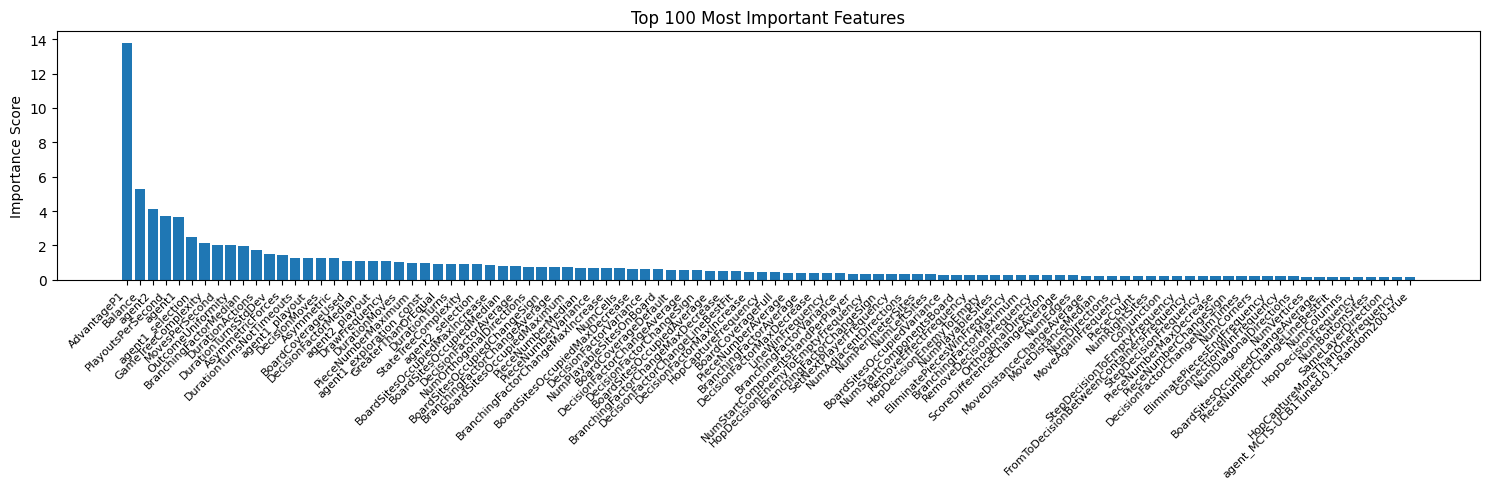

Fold 2 - RMSE: 0.40949326317795315
Fold 3


0:	learn: 0.6097106	test: 0.5695197	best: 0.5695197 (0)	total: 82.6ms	remaining: 4m 7s


50:	learn: 0.3854329	test: 0.4577171	best: 0.4577171 (50)	total: 4.12s	remaining: 3m 58s


100:	learn: 0.3452260	test: 0.4396283	best: 0.4396283 (100)	total: 8.31s	remaining: 3m 58s


150:	learn: 0.3226194	test: 0.4328127	best: 0.4328127 (150)	total: 12.5s	remaining: 3m 55s


200:	learn: 0.3077288	test: 0.4284017	best: 0.4284017 (200)	total: 16.6s	remaining: 3m 51s


250:	learn: 0.2963410	test: 0.4260520	best: 0.4260520 (250)	total: 20.8s	remaining: 3m 48s


300:	learn: 0.2867813	test: 0.4248345	best: 0.4248306 (299)	total: 25.1s	remaining: 3m 45s


350:	learn: 0.2780315	test: 0.4235123	best: 0.4234864 (349)	total: 29.3s	remaining: 3m 40s


400:	learn: 0.2707810	test: 0.4223369	best: 0.4223369 (400)	total: 33.5s	remaining: 3m 37s


450:	learn: 0.2646878	test: 0.4218484	best: 0.4217392 (421)	total: 37.8s	remaining: 3m 33s


500:	learn: 0.2588370	test: 0.4209378	best: 0.4209378 (500)	total: 42s	remaining: 3m 29s


550:	learn: 0.2541432	test: 0.4205966	best: 0.4205460 (547)	total: 46.2s	remaining: 3m 25s


600:	learn: 0.2498082	test: 0.4201691	best: 0.4201691 (600)	total: 50.5s	remaining: 3m 21s


650:	learn: 0.2458605	test: 0.4196789	best: 0.4196638 (648)	total: 54.8s	remaining: 3m 17s


700:	learn: 0.2421186	test: 0.4191871	best: 0.4191871 (700)	total: 59.1s	remaining: 3m 13s


750:	learn: 0.2385226	test: 0.4190233	best: 0.4190190 (749)	total: 1m 3s	remaining: 3m 10s


800:	learn: 0.2352564	test: 0.4185375	best: 0.4185353 (799)	total: 1m 7s	remaining: 3m 6s


850:	learn: 0.2322824	test: 0.4184434	best: 0.4184434 (850)	total: 1m 12s	remaining: 3m 2s


900:	learn: 0.2292960	test: 0.4180002	best: 0.4180002 (900)	total: 1m 16s	remaining: 2m 57s


950:	learn: 0.2264823	test: 0.4177032	best: 0.4177032 (950)	total: 1m 20s	remaining: 2m 53s


1000:	learn: 0.2239716	test: 0.4176083	best: 0.4175677 (997)	total: 1m 24s	remaining: 2m 49s


1050:	learn: 0.2213127	test: 0.4173048	best: 0.4173048 (1050)	total: 1m 29s	remaining: 2m 45s


1100:	learn: 0.2188656	test: 0.4171873	best: 0.4171873 (1100)	total: 1m 33s	remaining: 2m 41s


1150:	learn: 0.2164921	test: 0.4169562	best: 0.4169562 (1150)	total: 1m 37s	remaining: 2m 36s


1200:	learn: 0.2143297	test: 0.4168745	best: 0.4168341 (1197)	total: 1m 42s	remaining: 2m 32s


1250:	learn: 0.2122095	test: 0.4167840	best: 0.4167764 (1246)	total: 1m 46s	remaining: 2m 28s


1300:	learn: 0.2099843	test: 0.4167614	best: 0.4167200 (1267)	total: 1m 50s	remaining: 2m 24s


1350:	learn: 0.2078964	test: 0.4167989	best: 0.4167200 (1267)	total: 1m 54s	remaining: 2m 20s


1400:	learn: 0.2059249	test: 0.4166832	best: 0.4166686 (1384)	total: 1m 59s	remaining: 2m 15s


1450:	learn: 0.2040919	test: 0.4166190	best: 0.4166069 (1427)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2024525	test: 0.4164874	best: 0.4164758 (1494)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.2007990	test: 0.4163878	best: 0.4163763 (1539)	total: 2m 11s	remaining: 2m 3s


1600:	learn: 0.1991419	test: 0.4164228	best: 0.4163695 (1557)	total: 2m 16s	remaining: 1m 59s


1650:	learn: 0.1974713	test: 0.4163663	best: 0.4163369 (1635)	total: 2m 20s	remaining: 1m 54s


1700:	learn: 0.1958251	test: 0.4163412	best: 0.4163214 (1687)	total: 2m 24s	remaining: 1m 50s


1750:	learn: 0.1943433	test: 0.4163385	best: 0.4163214 (1687)	total: 2m 29s	remaining: 1m 46s


1800:	learn: 0.1926190	test: 0.4162988	best: 0.4162973 (1799)	total: 2m 33s	remaining: 1m 42s


1850:	learn: 0.1911225	test: 0.4162777	best: 0.4162561 (1823)	total: 2m 37s	remaining: 1m 37s


1900:	learn: 0.1895723	test: 0.4162266	best: 0.4161872 (1888)	total: 2m 41s	remaining: 1m 33s


1950:	learn: 0.1881260	test: 0.4161836	best: 0.4161827 (1946)	total: 2m 46s	remaining: 1m 29s


2000:	learn: 0.1869080	test: 0.4161947	best: 0.4161698 (1951)	total: 2m 50s	remaining: 1m 25s


2050:	learn: 0.1854549	test: 0.4161950	best: 0.4161584 (2019)	total: 2m 55s	remaining: 1m 21s


2100:	learn: 0.1840504	test: 0.4161873	best: 0.4161584 (2019)	total: 2m 59s	remaining: 1m 16s


2150:	learn: 0.1826433	test: 0.4162088	best: 0.4161584 (2019)	total: 3m 3s	remaining: 1m 12s


2200:	learn: 0.1812269	test: 0.4161380	best: 0.4161335 (2196)	total: 3m 8s	remaining: 1m 8s


2250:	learn: 0.1799760	test: 0.4161172	best: 0.4161036 (2231)	total: 3m 12s	remaining: 1m 4s


2300:	learn: 0.1786735	test: 0.4161573	best: 0.4161036 (2231)	total: 3m 16s	remaining: 59.7s


2350:	learn: 0.1774600	test: 0.4161862	best: 0.4161036 (2231)	total: 3m 20s	remaining: 55.4s


2400:	learn: 0.1761136	test: 0.4162413	best: 0.4161036 (2231)	total: 3m 25s	remaining: 51.2s


2450:	learn: 0.1747957	test: 0.4162199	best: 0.4161036 (2231)	total: 3m 29s	remaining: 46.9s


2500:	learn: 0.1736026	test: 0.4162153	best: 0.4161036 (2231)	total: 3m 33s	remaining: 42.6s


2550:	learn: 0.1724966	test: 0.4163698	best: 0.4161036 (2231)	total: 3m 38s	remaining: 38.4s


2600:	learn: 0.1712601	test: 0.4164053	best: 0.4161036 (2231)	total: 3m 42s	remaining: 34.1s


2650:	learn: 0.1701291	test: 0.4163692	best: 0.4161036 (2231)	total: 3m 46s	remaining: 29.8s


2700:	learn: 0.1689465	test: 0.4163387	best: 0.4161036 (2231)	total: 3m 50s	remaining: 25.6s


2750:	learn: 0.1678514	test: 0.4163516	best: 0.4161036 (2231)	total: 3m 55s	remaining: 21.3s


2800:	learn: 0.1668585	test: 0.4163163	best: 0.4161036 (2231)	total: 3m 59s	remaining: 17s


2850:	learn: 0.1658262	test: 0.4163586	best: 0.4161036 (2231)	total: 4m 3s	remaining: 12.7s


2900:	learn: 0.1646662	test: 0.4163993	best: 0.4161036 (2231)	total: 4m 8s	remaining: 8.47s


2950:	learn: 0.1635440	test: 0.4164315	best: 0.4161036 (2231)	total: 4m 12s	remaining: 4.19s


2999:	learn: 0.1624631	test: 0.4163837	best: 0.4161036 (2231)	total: 4m 16s	remaining: 0us

bestTest = 0.4161036397
bestIteration = 2231

Shrink model to first 2232 iterations.


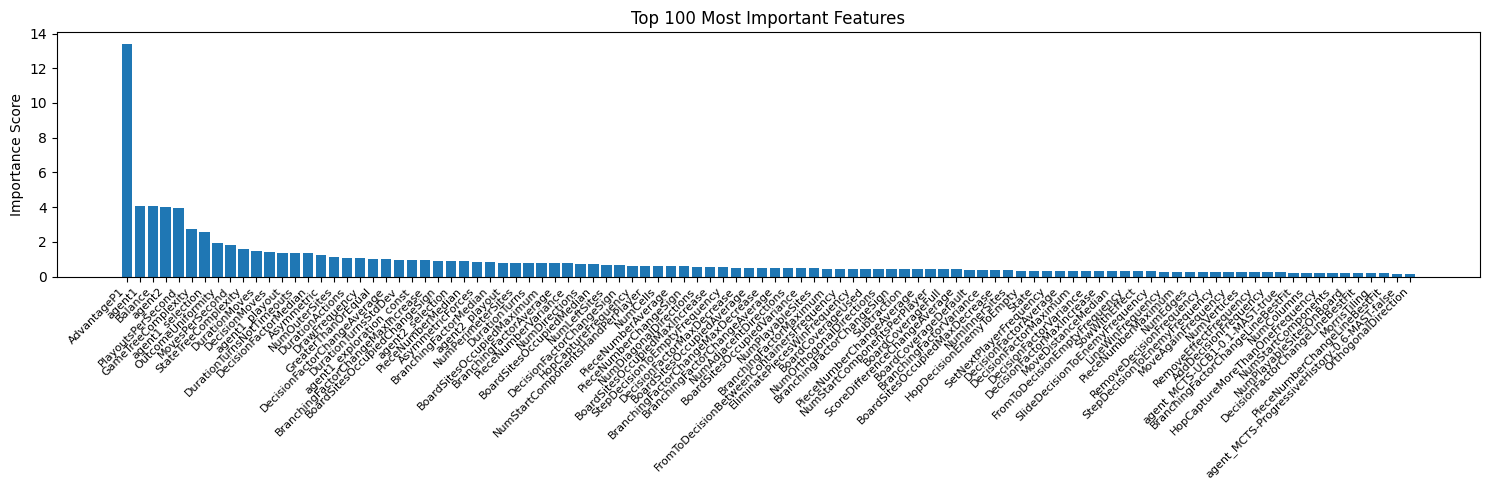

Fold 3 - RMSE: 0.41566694129427123
Fold 4


0:	learn: 0.6103761	test: 0.5672324	best: 0.5672324 (0)	total: 79.3ms	remaining: 3m 57s


50:	learn: 0.3893475	test: 0.4636672	best: 0.4636672 (50)	total: 4.1s	remaining: 3m 57s


100:	learn: 0.3479416	test: 0.4478112	best: 0.4478112 (100)	total: 8.3s	remaining: 3m 58s


150:	learn: 0.3251194	test: 0.4411370	best: 0.4411370 (150)	total: 12.5s	remaining: 3m 55s


200:	learn: 0.3104930	test: 0.4368146	best: 0.4368146 (200)	total: 16.8s	remaining: 3m 53s


250:	learn: 0.2991649	test: 0.4351744	best: 0.4351744 (250)	total: 21s	remaining: 3m 50s


300:	learn: 0.2902287	test: 0.4335966	best: 0.4335966 (300)	total: 25.2s	remaining: 3m 45s


350:	learn: 0.2823768	test: 0.4318751	best: 0.4318751 (350)	total: 29.4s	remaining: 3m 41s


400:	learn: 0.2753963	test: 0.4304615	best: 0.4304615 (400)	total: 33.7s	remaining: 3m 38s


450:	learn: 0.2692181	test: 0.4301348	best: 0.4301263 (446)	total: 37.9s	remaining: 3m 34s


500:	learn: 0.2639218	test: 0.4294780	best: 0.4294780 (500)	total: 42.1s	remaining: 3m 30s


550:	learn: 0.2590654	test: 0.4290179	best: 0.4289802 (545)	total: 46.4s	remaining: 3m 26s


600:	learn: 0.2548121	test: 0.4287645	best: 0.4287519 (596)	total: 50.6s	remaining: 3m 22s


650:	learn: 0.2507844	test: 0.4281005	best: 0.4281005 (650)	total: 54.9s	remaining: 3m 17s


700:	learn: 0.2467917	test: 0.4274581	best: 0.4274581 (700)	total: 59.1s	remaining: 3m 13s


750:	learn: 0.2431379	test: 0.4272519	best: 0.4272519 (750)	total: 1m 3s	remaining: 3m 9s


800:	learn: 0.2393203	test: 0.4270867	best: 0.4270472 (784)	total: 1m 7s	remaining: 3m 5s


850:	learn: 0.2360385	test: 0.4270263	best: 0.4270073 (847)	total: 1m 11s	remaining: 3m 1s


900:	learn: 0.2331683	test: 0.4266924	best: 0.4266924 (900)	total: 1m 16s	remaining: 2m 57s


950:	learn: 0.2304273	test: 0.4263435	best: 0.4263435 (950)	total: 1m 20s	remaining: 2m 53s


1000:	learn: 0.2274209	test: 0.4260935	best: 0.4260935 (1000)	total: 1m 24s	remaining: 2m 49s


1050:	learn: 0.2248710	test: 0.4258336	best: 0.4258031 (1046)	total: 1m 29s	remaining: 2m 45s


1100:	learn: 0.2227322	test: 0.4257144	best: 0.4257144 (1100)	total: 1m 33s	remaining: 2m 41s


1150:	learn: 0.2203207	test: 0.4256566	best: 0.4256534 (1149)	total: 1m 37s	remaining: 2m 36s


1200:	learn: 0.2180747	test: 0.4255216	best: 0.4255172 (1197)	total: 1m 41s	remaining: 2m 32s


1250:	learn: 0.2159957	test: 0.4254375	best: 0.4254336 (1249)	total: 1m 46s	remaining: 2m 28s


1300:	learn: 0.2138929	test: 0.4254568	best: 0.4253863 (1286)	total: 1m 50s	remaining: 2m 24s


1350:	learn: 0.2119177	test: 0.4254254	best: 0.4253863 (1286)	total: 1m 54s	remaining: 2m 19s


1400:	learn: 0.2100707	test: 0.4254803	best: 0.4253863 (1286)	total: 1m 58s	remaining: 2m 15s


1450:	learn: 0.2080881	test: 0.4254474	best: 0.4253863 (1286)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2062691	test: 0.4254025	best: 0.4253761 (1498)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.2044468	test: 0.4253884	best: 0.4253267 (1543)	total: 2m 11s	remaining: 2m 3s


1600:	learn: 0.2027791	test: 0.4252664	best: 0.4252498 (1598)	total: 2m 15s	remaining: 1m 58s


1650:	learn: 0.2011084	test: 0.4251199	best: 0.4251199 (1650)	total: 2m 20s	remaining: 1m 54s


1700:	learn: 0.1994418	test: 0.4250206	best: 0.4250046 (1696)	total: 2m 24s	remaining: 1m 50s


1750:	learn: 0.1977408	test: 0.4249754	best: 0.4249278 (1729)	total: 2m 28s	remaining: 1m 46s


1800:	learn: 0.1962122	test: 0.4248645	best: 0.4248563 (1798)	total: 2m 33s	remaining: 1m 41s


1850:	learn: 0.1947319	test: 0.4248204	best: 0.4248068 (1840)	total: 2m 37s	remaining: 1m 37s


1900:	learn: 0.1932080	test: 0.4247579	best: 0.4247344 (1893)	total: 2m 41s	remaining: 1m 33s


1950:	learn: 0.1916932	test: 0.4247959	best: 0.4247344 (1893)	total: 2m 45s	remaining: 1m 29s


2000:	learn: 0.1901448	test: 0.4247499	best: 0.4247344 (1893)	total: 2m 50s	remaining: 1m 24s


2050:	learn: 0.1887336	test: 0.4247486	best: 0.4247161 (2045)	total: 2m 54s	remaining: 1m 20s


2100:	learn: 0.1873689	test: 0.4246746	best: 0.4246717 (2097)	total: 2m 58s	remaining: 1m 16s


2150:	learn: 0.1858700	test: 0.4246111	best: 0.4246111 (2150)	total: 3m 2s	remaining: 1m 12s


2200:	learn: 0.1844958	test: 0.4246687	best: 0.4245857 (2166)	total: 3m 7s	remaining: 1m 7s


2250:	learn: 0.1831301	test: 0.4246187	best: 0.4245857 (2166)	total: 3m 11s	remaining: 1m 3s


2300:	learn: 0.1818564	test: 0.4245973	best: 0.4245857 (2166)	total: 3m 15s	remaining: 59.5s


2350:	learn: 0.1804847	test: 0.4245666	best: 0.4245491 (2315)	total: 3m 19s	remaining: 55.2s


2400:	learn: 0.1791127	test: 0.4245150	best: 0.4245121 (2399)	total: 3m 24s	remaining: 50.9s


2450:	learn: 0.1777323	test: 0.4245083	best: 0.4244885 (2416)	total: 3m 28s	remaining: 46.7s


2500:	learn: 0.1765639	test: 0.4244434	best: 0.4244434 (2500)	total: 3m 32s	remaining: 42.4s


2550:	learn: 0.1754436	test: 0.4243721	best: 0.4243642 (2549)	total: 3m 36s	remaining: 38.1s


2600:	learn: 0.1742886	test: 0.4243844	best: 0.4243368 (2561)	total: 3m 40s	remaining: 33.9s


2650:	learn: 0.1731702	test: 0.4243580	best: 0.4243368 (2561)	total: 3m 45s	remaining: 29.7s


2700:	learn: 0.1720077	test: 0.4243542	best: 0.4243320 (2686)	total: 3m 49s	remaining: 25.4s


2750:	learn: 0.1708913	test: 0.4243085	best: 0.4242966 (2742)	total: 3m 54s	remaining: 21.2s


2800:	learn: 0.1698324	test: 0.4243305	best: 0.4242966 (2742)	total: 3m 58s	remaining: 16.9s


2850:	learn: 0.1687567	test: 0.4243597	best: 0.4242966 (2742)	total: 4m 2s	remaining: 12.7s


2900:	learn: 0.1676691	test: 0.4242703	best: 0.4242703 (2900)	total: 4m 6s	remaining: 8.43s


2950:	learn: 0.1665612	test: 0.4242871	best: 0.4242556 (2919)	total: 4m 11s	remaining: 4.17s


2999:	learn: 0.1655906	test: 0.4243604	best: 0.4242556 (2919)	total: 4m 15s	remaining: 0us

bestTest = 0.424255602
bestIteration = 2919

Shrink model to first 2920 iterations.


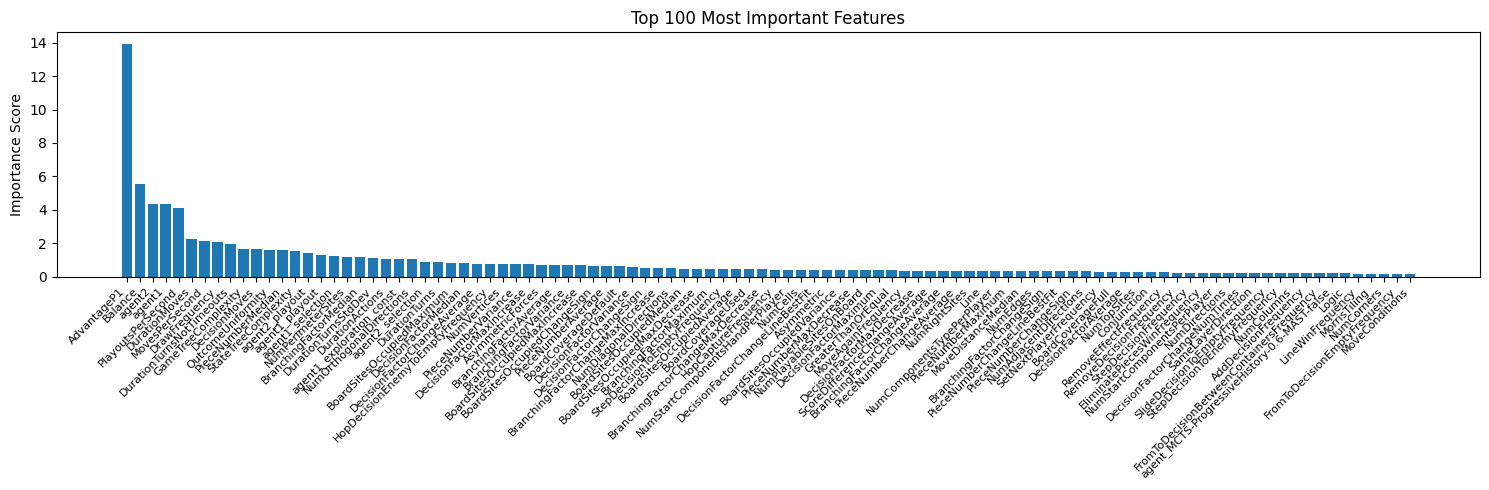

Fold 4 - RMSE: 0.42308551859291826
Fold 5


0:	learn: 0.6054760	test: 0.5805929	best: 0.5805929 (0)	total: 70.9ms	remaining: 3m 32s


50:	learn: 0.3869368	test: 0.4728424	best: 0.4728424 (50)	total: 4.23s	remaining: 4m 4s


100:	learn: 0.3457071	test: 0.4536086	best: 0.4536086 (100)	total: 8.54s	remaining: 4m 5s


150:	learn: 0.3234641	test: 0.4458781	best: 0.4458781 (150)	total: 12.8s	remaining: 4m


200:	learn: 0.3088322	test: 0.4405124	best: 0.4405124 (200)	total: 17.1s	remaining: 3m 57s


250:	learn: 0.2976277	test: 0.4368211	best: 0.4368211 (250)	total: 21.3s	remaining: 3m 52s


300:	learn: 0.2886386	test: 0.4346603	best: 0.4346356 (298)	total: 25.6s	remaining: 3m 49s


350:	learn: 0.2810329	test: 0.4335328	best: 0.4335328 (350)	total: 29.9s	remaining: 3m 45s


400:	learn: 0.2739709	test: 0.4327618	best: 0.4326855 (395)	total: 34.5s	remaining: 3m 43s


450:	learn: 0.2680279	test: 0.4318038	best: 0.4318038 (450)	total: 38.9s	remaining: 3m 39s


500:	learn: 0.2622658	test: 0.4313429	best: 0.4312906 (499)	total: 43.1s	remaining: 3m 35s


550:	learn: 0.2573955	test: 0.4304808	best: 0.4304360 (547)	total: 47.5s	remaining: 3m 30s


600:	learn: 0.2528287	test: 0.4299999	best: 0.4299999 (600)	total: 51.8s	remaining: 3m 26s


650:	learn: 0.2491025	test: 0.4296196	best: 0.4295843 (638)	total: 56.2s	remaining: 3m 22s


700:	learn: 0.2451150	test: 0.4293394	best: 0.4293394 (700)	total: 1m	remaining: 3m 18s


750:	learn: 0.2418081	test: 0.4293394	best: 0.4292318 (727)	total: 1m 4s	remaining: 3m 14s


800:	learn: 0.2383669	test: 0.4287837	best: 0.4287665 (799)	total: 1m 9s	remaining: 3m 9s


850:	learn: 0.2353188	test: 0.4287535	best: 0.4287256 (835)	total: 1m 13s	remaining: 3m 5s


900:	learn: 0.2324905	test: 0.4285100	best: 0.4285100 (900)	total: 1m 17s	remaining: 3m 1s


950:	learn: 0.2296336	test: 0.4282827	best: 0.4282827 (950)	total: 1m 22s	remaining: 2m 57s


1000:	learn: 0.2270378	test: 0.4282063	best: 0.4281423 (990)	total: 1m 26s	remaining: 2m 52s


1050:	learn: 0.2243183	test: 0.4279854	best: 0.4279608 (1048)	total: 1m 30s	remaining: 2m 48s


1100:	learn: 0.2219305	test: 0.4277909	best: 0.4277867 (1099)	total: 1m 35s	remaining: 2m 44s


1150:	learn: 0.2198061	test: 0.4276934	best: 0.4276810 (1148)	total: 1m 39s	remaining: 2m 40s


1200:	learn: 0.2177453	test: 0.4274087	best: 0.4274087 (1200)	total: 1m 44s	remaining: 2m 36s


1250:	learn: 0.2155495	test: 0.4271054	best: 0.4270984 (1249)	total: 1m 48s	remaining: 2m 31s


1300:	learn: 0.2135089	test: 0.4270839	best: 0.4270493 (1298)	total: 1m 52s	remaining: 2m 27s


1350:	learn: 0.2115226	test: 0.4269825	best: 0.4269658 (1325)	total: 1m 57s	remaining: 2m 23s


1400:	learn: 0.2095011	test: 0.4270943	best: 0.4269658 (1325)	total: 2m 1s	remaining: 2m 18s


1450:	learn: 0.2077753	test: 0.4270096	best: 0.4269658 (1325)	total: 2m 5s	remaining: 2m 14s


1500:	learn: 0.2059124	test: 0.4269504	best: 0.4269504 (1500)	total: 2m 10s	remaining: 2m 10s


1550:	learn: 0.2043101	test: 0.4270195	best: 0.4269436 (1506)	total: 2m 14s	remaining: 2m 5s


1600:	learn: 0.2026369	test: 0.4269528	best: 0.4269342 (1571)	total: 2m 19s	remaining: 2m 1s


1650:	learn: 0.2010914	test: 0.4270027	best: 0.4269334 (1605)	total: 2m 23s	remaining: 1m 57s


1700:	learn: 0.1995281	test: 0.4269725	best: 0.4269334 (1605)	total: 2m 27s	remaining: 1m 52s


1750:	learn: 0.1981090	test: 0.4268736	best: 0.4268399 (1733)	total: 2m 32s	remaining: 1m 48s


1800:	learn: 0.1964968	test: 0.4268247	best: 0.4268247 (1800)	total: 2m 36s	remaining: 1m 44s


1850:	learn: 0.1950534	test: 0.4267646	best: 0.4267646 (1850)	total: 2m 41s	remaining: 1m 40s


1900:	learn: 0.1935765	test: 0.4267699	best: 0.4267622 (1889)	total: 2m 45s	remaining: 1m 35s


1950:	learn: 0.1920063	test: 0.4267610	best: 0.4267465 (1921)	total: 2m 49s	remaining: 1m 31s


2000:	learn: 0.1905782	test: 0.4266782	best: 0.4266782 (2000)	total: 2m 54s	remaining: 1m 27s


2050:	learn: 0.1892331	test: 0.4265241	best: 0.4265172 (2042)	total: 2m 58s	remaining: 1m 22s


2100:	learn: 0.1879015	test: 0.4264929	best: 0.4264882 (2094)	total: 3m 3s	remaining: 1m 18s


2150:	learn: 0.1865926	test: 0.4264588	best: 0.4264583 (2137)	total: 3m 7s	remaining: 1m 13s


2200:	learn: 0.1852947	test: 0.4264878	best: 0.4264484 (2155)	total: 3m 11s	remaining: 1m 9s


2250:	learn: 0.1839662	test: 0.4264687	best: 0.4264451 (2229)	total: 3m 16s	remaining: 1m 5s


2300:	learn: 0.1825919	test: 0.4264591	best: 0.4264451 (2229)	total: 3m 20s	remaining: 1m


2350:	learn: 0.1812258	test: 0.4264848	best: 0.4264404 (2309)	total: 3m 24s	remaining: 56.6s


2400:	learn: 0.1799968	test: 0.4264308	best: 0.4264281 (2394)	total: 3m 29s	remaining: 52.2s


2450:	learn: 0.1788428	test: 0.4264334	best: 0.4264223 (2413)	total: 3m 33s	remaining: 47.9s


2500:	learn: 0.1776076	test: 0.4264078	best: 0.4263798 (2486)	total: 3m 38s	remaining: 43.5s


2550:	learn: 0.1764497	test: 0.4263226	best: 0.4263192 (2534)	total: 3m 42s	remaining: 39.2s


2600:	learn: 0.1751977	test: 0.4262843	best: 0.4262629 (2583)	total: 3m 46s	remaining: 34.8s


2650:	learn: 0.1740444	test: 0.4262421	best: 0.4262381 (2649)	total: 3m 51s	remaining: 30.4s


2700:	learn: 0.1729285	test: 0.4262820	best: 0.4262381 (2649)	total: 3m 55s	remaining: 26.1s


2750:	learn: 0.1718058	test: 0.4262687	best: 0.4262381 (2649)	total: 3m 59s	remaining: 21.7s


2800:	learn: 0.1706954	test: 0.4262830	best: 0.4262381 (2649)	total: 4m 4s	remaining: 17.4s


2850:	learn: 0.1695245	test: 0.4263809	best: 0.4262381 (2649)	total: 4m 8s	remaining: 13s


2900:	learn: 0.1684470	test: 0.4264046	best: 0.4262381 (2649)	total: 4m 12s	remaining: 8.63s


2950:	learn: 0.1674215	test: 0.4264250	best: 0.4262381 (2649)	total: 4m 17s	remaining: 4.27s


2999:	learn: 0.1663857	test: 0.4263745	best: 0.4262381 (2649)	total: 4m 21s	remaining: 0us

bestTest = 0.4262381022
bestIteration = 2649

Shrink model to first 2650 iterations.


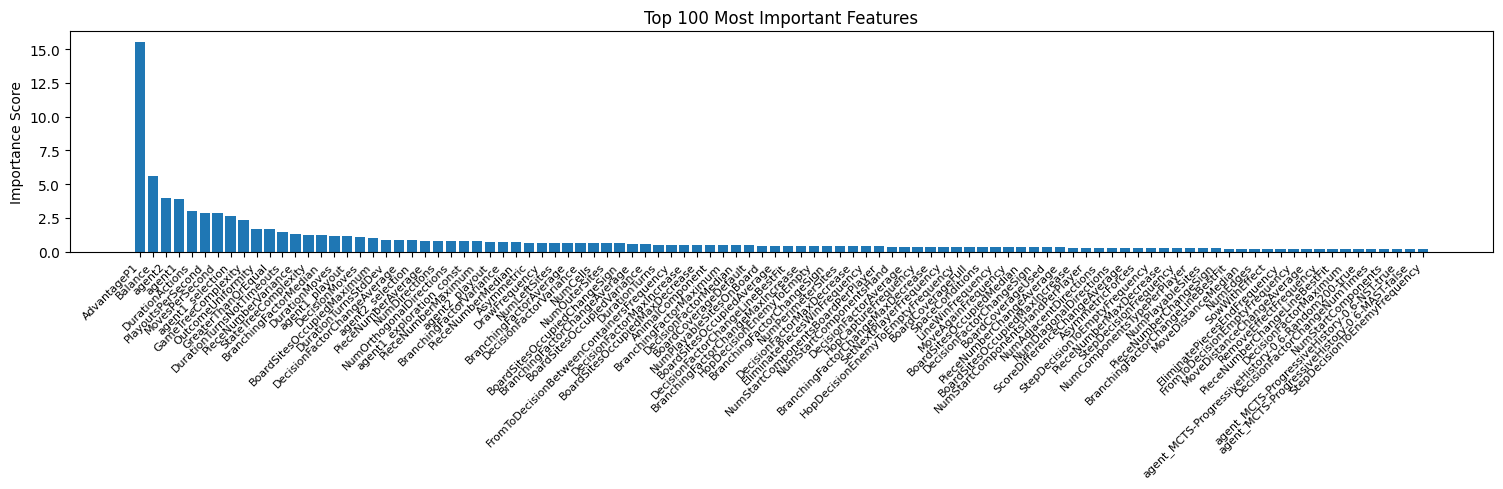

Fold 5 - RMSE: 0.42560090717511934
List of oof scores: [0.43038962311358264, 0.40949326317795315, 0.41566694129427123, 0.42308551859291826, 0.42560090717511934]
Average oof score: 0.42084725067076895


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4209
Score: 0.4400
Score: 0.4255
Score: 0.4411
Score: 0.4063
Average CV1 Score: 0.4268

CV2 OOF Scores:
Score: 0.4070
Score: 0.3978
Score: 0.4310
Score: 0.4396
Score: 0.4377
Average CV2 Score: 0.4226

CV3 OOF Scores:
Score: 0.4304
Score: 0.4095
Score: 0.4157
Score: 0.4231
Score: 0.4256
Average CV3 Score: 0.4208


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

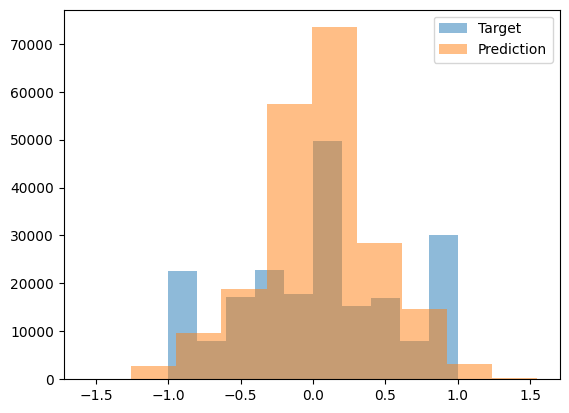

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.153102       │
│ 233235 ┆ -0.188214      │
│ 233236 ┆ 0.005511       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***